In [1]:
import scatrex
from scatrex import models
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import time

## Simulate data

In [2]:
seed = 42

sim_sca = scatrex.SCATrEx(model=models.cna, verbose=True)

observed_tree_args = dict(n_nodes=4, node_weights=np.array([.1, 1, 1, 1]))
observed_tree_params = dict(n_regions=30, min_cn=1, min_nevents=5, max_nevents_frac=.5)
sim_sca.simulate_tree(observed_tree=None, n_extra_per_observed=1, n_genes=800, seed=seed,
                        observed_tree_params=observed_tree_params, observed_tree_args=observed_tree_args)
sim_sca.observed_tree.create_adata()

theta = 100
sim_sca.ntssb.reset_node_parameters(node_hyperparams=dict(log_lib_size_mean=7.1, log_lib_size_std=.6, 
                                                          num_global_noise_factors=4,
                                                          global_noise_factors_precisions_shape=5,
                                                          unobserved_factors_kernel_concentration=1./theta,
                                                          frac_dosage=1.,
                                                          baseline_shape=.7))

sim_sca.simulate_data(n_cells=1000, copy=False, seed=seed)

Generating an observed CNA tree
n_nodes: 4
node_weights: [0.1 1.  1.  1. ]
Generating an augmented CNA tree
Tree is stored in `self.observed_tree` and `self.ntssb`


/cluster/home/pedrof/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Labeled data are stored in `self.adata`


/cluster/home/pedrof/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'node' as categorical
/cluster/home/pedrof/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'obs_node' as categorical


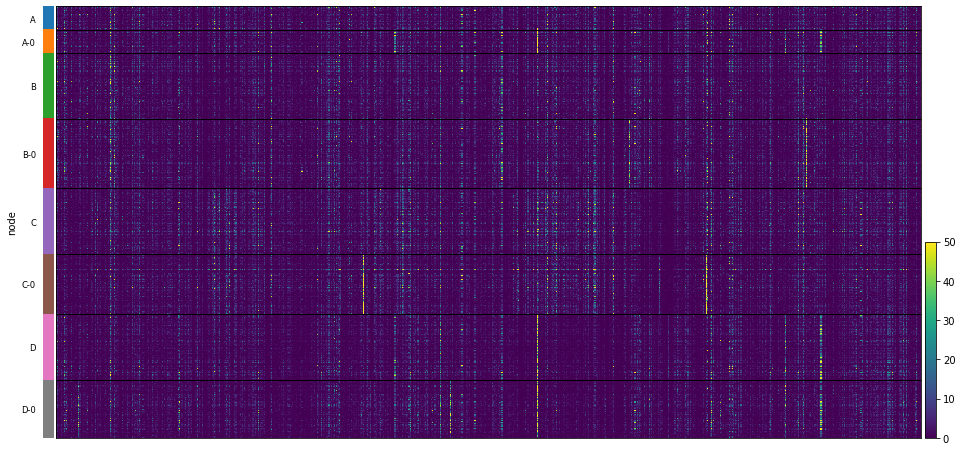

In [4]:
sc.pl.heatmap(sim_sca.adata, groupby='node', var_names=sim_sca.adata.var_names, use_raw=True, vmax=50, figsize=(16,8))

/cluster/home/pedrof/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'node' as categorical


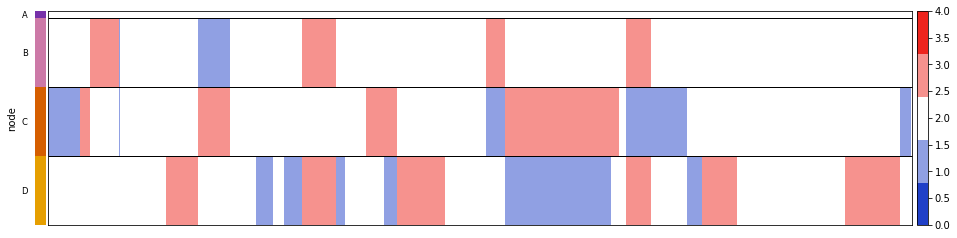

In [5]:
sim_sca.observed_tree.plot_heatmap(vmax=4, vmin=0, figsize=(16,4))

## Run SCATrEx

In [7]:
theta = 100
args = dict(global_noise_factors_precisions_shape=100, num_global_noise_factors=4, 
            unobserved_factors_kernel_concentration=1/theta,
            unobserved_factors_kernel_rate=1.,
            unobserved_factors_root_kernel=.01)
sca = scatrex.SCATrEx(model=models.cna, verbose=True, model_args=args)
sca.model_args = args
sca.add_data(sim_sca.adata.raw.to_adata())
sca.set_observed_tree(sim_sca.observed_tree)
sca.normalize_data()
sca.project_data()

move_weights = {'add':3,
                'merge':6,
                'prune_reattach':1,
                'pivot_reattach':1,
                'swap':1,
                'add_reattach_pivot':.5,
                'subtree_reattach':.5,
                'push_subtree':.5,
                'extract_pivot':.5,
                'perturb_node':.0,
                'clean_node':.0,
                'subtree_pivot_reattach':.5,
                'reset_globals':.0,
                'full':.0,
                'globals':1}

search_kwargs = {'n_iters': 500, 'n_iters_elbo': 500,                
                'move_weights': move_weights,
                'local': True,
                'factor_delay': 0,
                'step_size': 0.01,
                'posterior_delay': 0,
                'mb_size': 200,
                'num_samples': 1,
                'window': 50,
                'max_nodes': 5,
                'add_rule_thres': .4,
                'joint_init': True,
                'anneal': False,
                'restart_step': 100}
sca.learn_tree(reset=True, search_kwargs=search_kwargs)

Normalized data are stored in `self.adata`
2-projected data are stored in `self.pca` and projection matrix in `self.pca_obj`
Filtered scRNA data for clonemap shape: (1000, 800)
Adding data of shape (1000, 800) to NTSSB
Will search for the maximum marginal likelihood tree with the following moves: ['add', 'merge', 'prune_reattach', 'pivot_reattach', 'swap', 'add_reattach_pivot', 'subtree_reattach', 'push_subtree', 'extract_pivot', 'perturb_node', 'clean_node', 'subtree_pivot_reattach', 'reset_globals', 'full', 'globals']

Recompiling objective!
Convergence achieved at 1600
Recompiling batch objective!


  0%|          | 0/500 [00:00<?, ?it/s]

Trying to swap B with A...
Won't take derivatives wrt global parameters
Convergence achieved at 350


  0%|          | 1/500 [00:03<29:32,  3.55s/it]

-967012.0 -> -998165.0625
Setting current tree with complete number of factors as the best.
New best! -967012.0
Won't take derivatives wrt local parameters


  0%|          | 2/500 [00:06<27:23,  3.30s/it]

*Move (merge) accepted. (-965193.5625 -> -965193.5625)*
New best! -965193.5625
Trying to swap B with A...
Won't take derivatives wrt global parameters
Convergence achieved at 450


  1%|          | 4/500 [00:08<21:35,  2.61s/it]

-965193.5625 -> -995236.3125
*Move (pivot_reattach) accepted. (-965193.5625 -> -965193.5625)*
Trying to add node below D
Initializing new node from noise factor


/cluster/apps/python/3.8.5_gpu_gcc630/x86_64/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/apps/python/3.8.5_gpu_gcc630/x86_64/lib64/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Convergence achieved at 350


  1%|          | 6/500 [00:11<19:37,  2.38s/it]

-965193.5625 -> -958886.8125
*Move (add) accepted. (-965193.5625 -> -958886.8125)*
New best! -958886.8125
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


  1%|▏         | 7/500 [00:14<20:47,  2.53s/it]

-958886.8125 -> -958315.5625
*Move (merge) accepted. (-958886.8125 -> -958315.5625)*
New best! -958315.5625
Trying to swap C with A...
Won't take derivatives wrt global parameters


  2%|▏         | 8/500 [00:17<20:21,  2.48s/it]

-958315.5625 -> -984412.0625
Trying to add node below C
Initializing new node from noise factor
Convergence achieved at 200


  2%|▏         | 9/500 [00:18<16:49,  2.06s/it]

-958315.5625 -> -995065.25
*Move (add) accepted. (-958315.5625 -> -995065.25)*
Trying to swap B with A...
Won't take derivatives wrt global parameters
Convergence achieved at 300


  2%|▏         | 10/500 [00:19<15:21,  1.88s/it]

-995065.25 -> -1012082.5
Trying to extract pivot from C
Won't take derivatives wrt global parameters


  2%|▏         | 11/500 [00:22<18:21,  2.25s/it]

-995065.25 -> -1002662.2669415418
Trying to add node A-3 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 250


  2%|▏         | 12/500 [00:25<18:05,  2.23s/it]

-995065.25 -> -993828.5169415418
*Move (add_reattach_pivot) accepted. (-995065.25 -> -993828.5169415418)*
Trying to set C-0 below A and use it as pivot of C
Won't take derivatives wrt global parameters


  3%|▎         | 13/500 [00:27<18:18,  2.25s/it]

-993828.5169415418 -> -1011795.6708368661
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 450


  3%|▎         | 14/500 [00:30<20:45,  2.56s/it]

-993828.5169415418 -> -938955.8294415418
*Move (add) accepted. (-993828.5169415418 -> -938955.8294415418)*
New best! -938955.8294415418
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 800


  3%|▎         | 15/500 [00:35<25:50,  3.20s/it]

-938955.8294415418 -> -927713.7669415418
*Move (add) accepted. (-938955.8294415418 -> -927713.7669415418)*
New best! -927713.7669415418
Trying to extract pivot from D
Won't take derivatives wrt global parameters


  3%|▎         | 16/500 [00:39<27:16,  3.38s/it]

-927713.7669415418 -> -934814.7958368661
Trying to extract pivot from B
Won't take derivatives wrt global parameters


  3%|▎         | 17/500 [00:42<26:15,  3.26s/it]

-927713.7669415418 -> -947911.9208368661
Trying to merge B-0 to B-1...
Won't take derivatives wrt global parameters


  4%|▎         | 18/500 [00:44<23:17,  2.90s/it]

Convergence achieved at 400
-927713.7669415418 -> -934406.5794415418
Won't take derivatives wrt local parameters
Convergence achieved at 200


  4%|▍         | 19/500 [00:45<20:38,  2.57s/it]

Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


  4%|▍         | 20/500 [00:48<20:09,  2.52s/it]

-926292.3294415418 -> -966785.125
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters
Convergence achieved at 450


  4%|▍         | 21/500 [00:50<20:13,  2.53s/it]

-926292.3294415418 -> -934944.0169415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


  4%|▍         | 22/500 [00:52<18:05,  2.27s/it]

Convergence achieved at 300
-926292.3294415418 -> -935382.2669415418
Trying to merge B-1 to B-0...
Won't take derivatives wrt global parameters
Convergence achieved at 450
-926292.3294415418 -> -933112.3919415418


  5%|▍         | 23/500 [00:54<17:40,  2.22s/it]

Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


  5%|▍         | 24/500 [00:57<17:56,  2.26s/it]

-926292.3294415418 -> -925318.3919415418
*Move (merge) accepted. (-926292.3294415418 -> -925318.3919415418)*
New best! -925318.3919415418
Trying to add node below D
Initializing new node from noise factor


  5%|▌         | 25/500 [01:01<22:59,  2.90s/it]

-925318.3919415418 -> -921488.7669415418
*Move (add) accepted. (-925318.3919415418 -> -921488.7669415418)*
New best! -921488.7669415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


  5%|▌         | 26/500 [01:03<20:30,  2.60s/it]

Convergence achieved at 400
-921488.7669415418 -> -931080.8294415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


  5%|▌         | 27/500 [01:05<19:58,  2.53s/it]

-921488.7669415418 -> -950771.125
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


  6%|▌         | 28/500 [01:06<16:28,  2.09s/it]

Convergence achieved at 200
-921488.7669415418 -> -943322.3919415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


  6%|▌         | 29/500 [01:08<14:59,  1.91s/it]

Convergence achieved at 300
-921488.7669415418 -> -945655.7669415418
Trying to push B down
Won't take derivatives wrt global parameters


  6%|▌         | 30/500 [01:10<15:50,  2.02s/it]

-921488.7669415418 -> -926490.7958368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 250
-921488.7669415418 -> -925829.9544415418


  6%|▌         | 31/500 [01:11<14:07,  1.81s/it]

Trying to add node below D
Won't take derivatives wrt global parameters
Convergence achieved at 250


  6%|▋         | 32/500 [01:14<16:23,  2.10s/it]

-921488.7669415418 -> -924140.8919415418
*Move (add) accepted. (-921488.7669415418 -> -924140.8919415418)*
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


  7%|▋         | 33/500 [01:17<17:11,  2.21s/it]

-924140.8919415418 -> -941290.75
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


  7%|▋         | 34/500 [01:18<15:20,  1.98s/it]

Convergence achieved at 300
-924140.8919415418 -> -934241.3919415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


  7%|▋         | 35/500 [01:20<15:49,  2.04s/it]

-924140.8919415418 -> -946519.0794415418
Trying to add node below C-0
Initializing new node from noise factor
Convergence achieved at 400


  7%|▋         | 36/500 [01:23<17:55,  2.32s/it]

-924140.8919415418 -> -924417.3294415418
Trying to merge D-0 to D-1...
Won't take derivatives wrt global parameters
Convergence achieved at 150


  7%|▋         | 37/500 [01:25<15:54,  2.06s/it]

-924140.8919415418 -> -922311.5169415418
*Move (merge) accepted. (-924140.8919415418 -> -922311.5169415418)*
Trying to extract pivot from C
Won't take derivatives wrt global parameters


  8%|▊         | 38/500 [01:27<16:36,  2.16s/it]

-922311.5169415418 -> -940149.1708368661
*Move (prune_reattach) accepted. (-922311.5169415418 -> -922311.5169415418)*
Won't take derivatives wrt local parameters


  8%|▊         | 40/500 [01:30<15:05,  1.97s/it]

Trying to add node below D
Initializing new node from noise factor
Convergence achieved at 900


  8%|▊         | 41/500 [01:34<19:18,  2.52s/it]

-921656.3919415418 -> -922430.9544415418
*Move (add) accepted. (-921656.3919415418 -> -922430.9544415418)*
Trying to set B-0 below A and use it as pivot of B
Won't take derivatives wrt global parameters


  8%|▊         | 42/500 [01:36<18:26,  2.42s/it]

-922430.9544415418 -> -952265.1708368661
Trying to merge D-1 to D-1...
Won't take derivatives wrt global parameters


  9%|▊         | 43/500 [01:37<15:10,  1.99s/it]

Convergence achieved at 200
-922430.9544415418 -> -925919.3294415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


  9%|▉         | 44/500 [01:38<13:19,  1.75s/it]

Convergence achieved at 250
-922430.9544415418 -> -921830.8294415418
*Move (merge) accepted. (-922430.9544415418 -> -921830.8294415418)*
*Move (prune_reattach) accepted. (-921830.8294415418 -> -921830.8294415418)*
Trying to swap A-3 with D...
Won't take derivatives wrt global parameters
Convergence achieved at 400


  9%|▉         | 46/500 [01:41<11:58,  1.58s/it]

-921830.8294415418 -> -975432.8125
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


  9%|▉         | 47/500 [01:43<13:36,  1.80s/it]

-921830.8294415418 -> -926852.3919415418
Won't take derivatives wrt local parameters
Convergence achieved at 350


 10%|▉         | 48/500 [01:45<15:00,  1.99s/it]

Won't take derivatives wrt local parameters
Convergence achieved at 150


 10%|▉         | 49/500 [01:47<14:24,  1.92s/it]

Trying to add node A-3-1 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 250


 10%|█         | 50/500 [01:49<13:57,  1.86s/it]

-920830.4544415418 -> -923435.7958368661
Trying to set B-0 below D
Won't take derivatives wrt global parameters


 10%|█         | 51/500 [01:51<15:28,  2.07s/it]

-920830.4544415418 -> -997957.0169415418
Won't take derivatives wrt local parameters
Convergence achieved at 150


 10%|█         | 52/500 [01:53<14:15,  1.91s/it]

Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 500


 11%|█         | 53/500 [01:55<15:09,  2.04s/it]

-921015.5169415418 -> -927137.0794415418
*Move (add) accepted. (-921015.5169415418 -> -927137.0794415418)*
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 11%|█         | 54/500 [01:57<15:18,  2.06s/it]

-927137.0794415418 -> -964091.375
Won't take derivatives wrt local parameters
Convergence achieved at 200


 11%|█         | 55/500 [01:59<14:51,  2.00s/it]

Trying to reattach B-0 to B-1...
Won't take derivatives wrt global parameters
Convergence achieved at 150
-923745.2044415418 -> -925440.5794415418


 11%|█         | 56/500 [02:00<12:25,  1.68s/it]

Trying to add node A-3-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 300


 11%|█▏        | 57/500 [02:02<12:32,  1.70s/it]

-923745.2044415418 -> -933122.5458368661
Trying to add node A-3-1 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 200


 12%|█▏        | 58/500 [02:03<11:46,  1.60s/it]

-923745.2044415418 -> -927192.8583368661
Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


 12%|█▏        | 59/500 [02:04<10:03,  1.37s/it]

Convergence achieved at 150
-923745.2044415418 -> -921539.6419415418
*Move (merge) accepted. (-923745.2044415418 -> -921539.6419415418)*
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 12%|█▏        | 60/500 [02:06<11:58,  1.63s/it]

-921539.6419415418 -> -959804.875
*Move (prune_reattach) accepted. (-921539.6419415418 -> -921539.6419415418)*
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 12%|█▏        | 62/500 [02:07<09:16,  1.27s/it]

Convergence achieved at 150
-921539.6419415418 -> -941317.4544415418
Trying to set C-0 below A and use it as pivot of C
Won't take derivatives wrt global parameters


 13%|█▎        | 63/500 [02:09<11:13,  1.54s/it]

-921539.6419415418 -> -951160.5458368661
Trying to add node below A-3
Initializing new node from noise factor
Convergence achieved at 550


 13%|█▎        | 64/500 [02:12<13:19,  1.83s/it]

-921539.6419415418 -> -925261.7958368661
*Move (add) accepted. (-921539.6419415418 -> -925261.7958368661)*
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 13%|█▎        | 65/500 [02:14<12:48,  1.77s/it]

Convergence achieved at 350
-925261.7958368661 -> -931210.3583368661
Trying to reattach A-0-0 to A...
Won't take derivatives wrt global parameters


 13%|█▎        | 66/500 [02:16<14:17,  1.98s/it]

-925261.7958368661 -> -1169403.4208368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 13%|█▎        | 67/500 [02:18<13:25,  1.86s/it]

Convergence achieved at 350
-925261.7958368661 -> -936810.8583368661
Trying to merge A-3-1 to A-3...
Won't take derivatives wrt global parameters
Convergence achieved at 150


 14%|█▎        | 68/500 [02:18<11:13,  1.56s/it]

-925261.7958368661 -> -923525.8294415418
*Move (merge) accepted. (-925261.7958368661 -> -923525.8294415418)*
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 14%|█▍        | 69/500 [02:20<10:27,  1.46s/it]

Convergence achieved at 250
-923525.8294415418 -> -946048.6419415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 14%|█▍        | 70/500 [02:22<11:55,  1.66s/it]

-923525.8294415418 -> -935122.9544415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 14%|█▍        | 71/500 [02:24<13:12,  1.85s/it]

-923525.8294415418 -> -962268.0625
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 14%|█▍        | 72/500 [02:26<13:48,  1.94s/it]

-923525.8294415418 -> -929150.0794415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 15%|█▍        | 73/500 [02:27<12:13,  1.72s/it]

Convergence achieved at 250
-923525.8294415418 -> -930089.5794415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 15%|█▍        | 74/500 [02:30<13:22,  1.88s/it]

-923525.8294415418 -> -962215.9375
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 15%|█▌        | 75/500 [02:32<14:05,  1.99s/it]

-923525.8294415418 -> -962469.0
Won't take derivatives wrt local parameters
Convergence achieved at 300


 15%|█▌        | 76/500 [02:34<14:17,  2.02s/it]

Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 15%|█▌        | 77/500 [02:35<12:05,  1.72s/it]

Convergence achieved at 200
-921132.1419415418 -> -942523.4544415418
Won't take derivatives wrt local parameters
Convergence achieved at 150


 16%|█▌        | 78/500 [02:37<11:39,  1.66s/it]

Trying to merge A-3 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 16%|█▌        | 79/500 [02:38<12:08,  1.73s/it]

-920834.4544415418 -> -967287.25
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 16%|█▌        | 80/500 [02:41<12:58,  1.85s/it]

-920834.4544415418 -> -942368.8919415418
Trying to extract pivot from B
Won't take derivatives wrt global parameters
Convergence achieved at 450


 16%|█▌        | 81/500 [02:43<13:17,  1.90s/it]

-920834.4544415418 -> -938692.4833368661
Trying to swap B with B-0...
Won't take derivatives wrt global parameters


 16%|█▋        | 82/500 [02:45<14:09,  2.03s/it]

-920834.4544415418 -> -930672.4544415418
Trying to set D-1 below B
Won't take derivatives wrt global parameters


 17%|█▋        | 83/500 [02:48<15:34,  2.24s/it]

-920834.4544415418 -> -976001.0794415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 17%|█▋        | 84/500 [02:49<14:09,  2.04s/it]

Convergence achieved at 300
-920834.4544415418 -> -926965.0169415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 17%|█▋        | 85/500 [02:51<14:25,  2.09s/it]

-920834.4544415418 -> -926391.5794415418
Trying to push C down
Won't take derivatives wrt global parameters


 17%|█▋        | 86/500 [02:53<13:52,  2.01s/it]

Convergence achieved at 400
-920834.4544415418 -> -934385.6708368661
Trying to swap D-1 with D...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 17%|█▋        | 87/500 [02:55<13:51,  2.01s/it]

-920834.4544415418 -> -921476.8919415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 18%|█▊        | 88/500 [02:56<11:24,  1.66s/it]

Convergence achieved at 150
-920834.4544415418 -> -940499.8294415418
Trying to add node below D-1
Won't take derivatives wrt global parameters
Convergence achieved at 200


 18%|█▊        | 89/500 [02:58<10:54,  1.59s/it]

-920834.4544415418 -> -922836.7044415418
*Move (add) accepted. (-920834.4544415418 -> -922836.7044415418)*
Trying to set D-1-0 below A
Won't take derivatives wrt global parameters


 18%|█▊        | 90/500 [03:00<12:05,  1.77s/it]

-922836.7044415418 -> -1406519.9208368661
Trying to swap C-0 with C...
Won't take derivatives wrt global parameters


 18%|█▊        | 91/500 [03:02<13:03,  1.91s/it]

-922836.7044415418 -> -945566.6419415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 18%|█▊        | 92/500 [03:04<13:51,  2.04s/it]

-922836.7044415418 -> -950938.5
Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 300


 19%|█▊        | 93/500 [03:07<15:28,  2.28s/it]

-922836.7044415418 -> -927379.1419415418
Trying to merge D-1-0 to D-1...
Won't take derivatives wrt global parameters
Convergence achieved at 150
-922836.7044415418 -> -920979.3294415418
*Move (merge) accepted. (-922836.7044415418 -> -920979.3294415418)*


 19%|█▉        | 94/500 [03:08<12:54,  1.91s/it]

New best! -920979.3294415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 19%|█▉        | 95/500 [03:10<13:36,  2.02s/it]

-920979.3294415418 -> -961287.625
Won't take derivatives wrt local parameters
Convergence achieved at 250


 19%|█▉        | 96/500 [03:12<13:21,  1.98s/it]

*Move (prune_reattach) accepted. (-920871.5794415418 -> -920871.5794415418)*
New best! -920871.5794415418
Trying to swap C-0 with C...
Won't take derivatives wrt global parameters


 20%|█▉        | 98/500 [03:15<11:30,  1.72s/it]

-920871.5794415418 -> -943867.7044415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 20%|█▉        | 99/500 [03:17<11:59,  1.79s/it]

Convergence achieved at 450
-920871.5794415418 -> -926416.5169415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 20%|██        | 100/500 [03:18<11:34,  1.74s/it]

Convergence achieved at 350
-920871.5794415418 -> -926652.9544415418
Trying to add node below C-0
Initializing new node from noise factor
Convergence achieved at 800


 20%|██        | 101/500 [03:22<15:00,  2.26s/it]

-920871.5794415418 -> -916333.5169415418
*Move (add) accepted. (-920871.5794415418 -> -916333.5169415418)*
New best! -916333.5169415418
Trying to push C down
Won't take derivatives wrt global parameters
Convergence achieved at 450


 20%|██        | 102/500 [03:24<14:28,  2.18s/it]

-916333.5169415418 -> -919793.8583368661
Trying to push B down
Won't take derivatives wrt global parameters


 21%|██        | 103/500 [03:25<12:32,  1.89s/it]

Convergence achieved at 250
-916333.5169415418 -> -925675.7958368661
Trying to swap C-0 with C...
Won't take derivatives wrt global parameters


 21%|██        | 104/500 [03:27<13:08,  1.99s/it]

-916333.5169415418 -> -918307.3294415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 21%|██        | 105/500 [03:29<11:58,  1.82s/it]

Convergence achieved at 300
-916333.5169415418 -> -921496.5794415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 21%|██        | 106/500 [03:30<10:25,  1.59s/it]

Convergence achieved at 200
-916333.5169415418 -> -937550.9544415418
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 400


 21%|██▏       | 107/500 [03:32<11:11,  1.71s/it]

-916333.5169415418 -> -923475.5169415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 22%|██▏       | 108/500 [03:34<12:05,  1.85s/it]

-916333.5169415418 -> -917440.4544415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 22%|██▏       | 109/500 [03:36<12:57,  1.99s/it]

-916333.5169415418 -> -962088.0625
Won't take derivatives wrt local parameters
Convergence achieved at 250


 22%|██▏       | 110/500 [03:38<12:49,  1.97s/it]

Trying to push D down
Won't take derivatives wrt global parameters
Convergence achieved at 450


 22%|██▏       | 111/500 [03:40<13:00,  2.01s/it]

-914987.0169415418 -> -920894.2333368661
Trying to add node A-3-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 450


 22%|██▏       | 112/500 [03:42<13:37,  2.11s/it]

-914987.0169415418 -> -919599.4208368661
Trying to swap D with D-1...
Won't take derivatives wrt global parameters
Convergence achieved at 350
-914987.0169415418 -> -915588.0169415418


 23%|██▎       | 113/500 [03:44<12:38,  1.96s/it]

Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 23%|██▎       | 114/500 [03:45<10:48,  1.68s/it]

Convergence achieved at 200
-914987.0169415418 -> -923250.3919415418
Won't take derivatives wrt local parameters


 23%|██▎       | 115/500 [03:48<13:06,  2.04s/it]

Trying to merge D-1 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 350
-914917.0169415418 -> -919974.4544415418


 23%|██▎       | 116/500 [03:50<12:16,  1.92s/it]

Trying to set C-0-0 below A and use it as pivot of C
Won't take derivatives wrt global parameters


 23%|██▎       | 117/500 [03:52<12:49,  2.01s/it]

-914917.0169415418 -> -936618.5458368661
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 450
-914917.0169415418 -> -935774.2669415418


 24%|██▎       | 118/500 [03:54<12:46,  2.01s/it]

Trying to swap C-0 with C...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 24%|██▍       | 119/500 [03:56<12:46,  2.01s/it]

-914917.0169415418 -> -918225.2044415418
Trying to add node below C-0-0
Initializing new node from noise factor
Convergence achieved at 600


 24%|██▍       | 120/500 [03:59<14:05,  2.23s/it]

-914917.0169415418 -> -917947.0169415418
Won't take derivatives wrt local parameters


 24%|██▍       | 121/500 [04:01<15:22,  2.43s/it]

Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 250


 24%|██▍       | 122/500 [04:04<14:48,  2.35s/it]

-914691.8919415418 -> -918112.0169415418
Trying to set A as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 450


 25%|██▍       | 123/500 [04:06<14:32,  2.31s/it]

-914691.8919415418 -> -965013.9544415418
Won't take derivatives wrt local parameters
Convergence achieved at 200


 25%|██▍       | 124/500 [04:08<13:30,  2.16s/it]

Trying to merge C-0-0 to C-0...
Won't take derivatives wrt global parameters
Convergence achieved at 150


 25%|██▌       | 125/500 [04:09<11:56,  1.91s/it]

-914662.8294415418 -> -945198.8294415418
Trying to merge C-0-0 to C-0...
Won't take derivatives wrt global parameters
Convergence achieved at 150
-914662.8294415418 -> -945198.7044415418


 25%|██▌       | 126/500 [04:10<10:18,  1.65s/it]

No moves accepted in 25 iterations. Using ll for 10 iterations.
Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 250


 25%|██▌       | 127/500 [04:12<10:13,  1.64s/it]

-914662.8294415418 -> -918115.3919415418
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 850


 26%|██▌       | 128/500 [04:15<13:58,  2.25s/it]

-914662.8294415418 -> -916717.9544415418
Trying to merge A-3 to A...
Won't take derivatives wrt global parameters


 26%|██▌       | 129/500 [04:18<13:57,  2.26s/it]

-914662.8294415418 -> -961600.625
Trying to reattach C-0-0 to C...
Won't take derivatives wrt global parameters


 26%|██▌       | 130/500 [04:19<13:06,  2.13s/it]

Convergence achieved at 400
-914662.8294415418 -> -918647.0169415418
*Move (prune_reattach) accepted. (-914662.8294415418 -> -918647.0169415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters
Convergence achieved at 200
-918647.0169415418 -> -914972.9544415418
*Move (merge) accepted. (-918647.0169415418 -> -914972.9544415418)*


 26%|██▌       | 131/500 [04:20<11:08,  1.81s/it]

New best! -914972.9544415418
Trying to swap B-0 with B...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 26%|██▋       | 132/500 [04:23<11:34,  1.89s/it]

-914972.9544415418 -> -928438.8919415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 27%|██▋       | 133/500 [04:25<12:15,  2.00s/it]

-914972.9544415418 -> -961453.75
Trying to merge C-0-0 to C...
Won't take derivatives wrt global parameters


 27%|██▋       | 134/500 [04:27<12:09,  1.99s/it]

Convergence achieved at 450
-914972.9544415418 -> -930093.0169415418
*Move (merge) accepted. (-914972.9544415418 -> -930093.0169415418)*
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 27%|██▋       | 135/500 [04:29<12:24,  2.04s/it]

-930093.0169415418 -> -936241.2044415418
Trying to add node below C
Initializing new node from noise factor


 27%|██▋       | 136/500 [04:33<16:20,  2.69s/it]

-930093.0169415418 -> -914900.2669415418
*Move (add) accepted. (-930093.0169415418 -> -914900.2669415418)*
New best! -914900.2669415418
Trying to add node below D
Initializing new node from noise factor
Convergence achieved at 650


 27%|██▋       | 137/500 [04:36<16:38,  2.75s/it]

-914900.2669415418 -> -916375.9544415418
*Move (add) accepted. (-914900.2669415418 -> -916375.9544415418)*
Won't take derivatives wrt local parameters


 28%|██▊       | 138/500 [04:39<16:47,  2.78s/it]

Trying to add node A-0-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 400


 28%|██▊       | 139/500 [04:41<15:33,  2.59s/it]

-914293.5794415418 -> -917292.7958368661
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 200
-914293.5794415418 -> -913722.1419415418
*Move (merge) accepted. (-914293.5794415418 -> -913722.1419415418)*


 28%|██▊       | 140/500 [04:42<12:45,  2.13s/it]

New best! -913722.1419415418
Trying to set C-0 below A and use it as pivot of C
Won't take derivatives wrt global parameters


 28%|██▊       | 141/500 [04:44<12:50,  2.15s/it]

-913722.1419415418 -> -952115.7333368661
*Move (prune_reattach) accepted. (-913722.1419415418 -> -913722.1419415418)*
Trying to add node below B-0
Initializing new node from noise factor
Convergence achieved at 350


 29%|██▊       | 143/500 [04:46<10:31,  1.77s/it]

-913722.1419415418 -> -923755.9544415418
*Move (add) accepted. (-913722.1419415418 -> -923755.9544415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 29%|██▉       | 144/500 [04:48<11:15,  1.90s/it]

-923755.9544415418 -> -936949.5794415418
Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters


 29%|██▉       | 145/500 [04:51<12:37,  2.13s/it]

-923755.9544415418 -> -930004.7044415418
Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 200
-923755.9544415418 -> -927154.1419415418


 29%|██▉       | 146/500 [04:52<11:24,  1.93s/it]

Won't take derivatives wrt local parameters


 29%|██▉       | 147/500 [04:55<13:05,  2.22s/it]

Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters


 30%|██▉       | 148/500 [04:58<13:46,  2.35s/it]

-916356.7044415418 -> -923676.0169415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 30%|██▉       | 149/500 [04:59<12:21,  2.11s/it]

Convergence achieved at 300
-916356.7044415418 -> -922222.8294415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 30%|███       | 150/500 [05:01<11:06,  1.90s/it]

Convergence achieved at 300
-916356.7044415418 -> -922219.5794415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 30%|███       | 151/500 [05:03<10:53,  1.87s/it]

Convergence achieved at 400
-916356.7044415418 -> -930814.2044415418
Trying to add node A-0-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 350


 30%|███       | 152/500 [05:05<11:14,  1.94s/it]

-916356.7044415418 -> -919991.4208368661
Trying to merge B-0-0 to B-0...
Won't take derivatives wrt global parameters


 31%|███       | 153/500 [05:06<09:17,  1.61s/it]

Convergence achieved at 150
-916356.7044415418 -> -914660.1419415418
*Move (merge) accepted. (-916356.7044415418 -> -914660.1419415418)*
Won't take derivatives wrt local parameters
Convergence achieved at 150


 31%|███       | 154/500 [05:07<09:22,  1.63s/it]

Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 31%|███       | 155/500 [05:09<10:10,  1.77s/it]

-914466.0794415418 -> -949825.75
*Move (prune_reattach) accepted. (-914466.0794415418 -> -914466.0794415418)*
Trying to swap C with C-0...
Won't take derivatives wrt global parameters
Convergence achieved at 300
-914466.0794415418 -> -935932.2044415418


 31%|███▏      | 157/500 [05:11<08:20,  1.46s/it]

Trying to swap C with A...
Won't take derivatives wrt global parameters


 32%|███▏      | 158/500 [05:13<09:45,  1.71s/it]

-914466.0794415418 -> -1145009.9544415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 32%|███▏      | 159/500 [05:15<10:43,  1.89s/it]

-914466.0794415418 -> -948597.5625
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 32%|███▏      | 160/500 [05:18<11:22,  2.01s/it]

-914466.0794415418 -> -948550.625
Trying to add node A-0-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 350


 32%|███▏      | 161/500 [05:20<11:37,  2.06s/it]

-914466.0794415418 -> -918249.1083368661
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 32%|███▏      | 162/500 [05:21<10:29,  1.86s/it]

Convergence achieved at 300
-914466.0794415418 -> -937430.1419415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 33%|███▎      | 163/500 [05:24<11:07,  1.98s/it]

-914466.0794415418 -> -948592.4375
Trying to add node below C
Initializing new node from noise factor
Convergence achieved at 350


 33%|███▎      | 164/500 [05:25<10:39,  1.90s/it]

-914466.0794415418 -> -924988.0794415418
*Move (add) accepted. (-914466.0794415418 -> -924988.0794415418)*
Trying to add node A-0-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 450


 33%|███▎      | 165/500 [05:28<11:21,  2.03s/it]

-924988.0794415418 -> -923885.2333368661
*Move (add_reattach_pivot) accepted. (-924988.0794415418 -> -923885.2333368661)*
Won't take derivatives wrt local parameters
Convergence achieved at 450


 33%|███▎      | 166/500 [05:30<12:27,  2.24s/it]

Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 200


 33%|███▎      | 167/500 [05:33<13:15,  2.39s/it]

-917751.0458368661 -> -922609.6083368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 34%|███▎      | 168/500 [05:35<11:52,  2.15s/it]

Convergence achieved at 300
-917751.0458368661 -> -923537.1083368661
Trying to set B-0 below A and use it as pivot of B
Won't take derivatives wrt global parameters


 34%|███▍      | 169/500 [05:37<11:55,  2.16s/it]

-917751.0458368661 -> -947298.4713830833
Trying to reattach C-0 to C-1...
Won't take derivatives wrt global parameters
Convergence achieved at 200


 34%|███▍      | 170/500 [05:38<10:05,  1.84s/it]

-917751.0458368661 -> -918144.6083368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters
Convergence achieved at 350


 34%|███▍      | 171/500 [05:40<09:50,  1.79s/it]

-917751.0458368661 -> -930277.1708368661
Trying to add node below D
Initializing new node from noise factor
Convergence achieved at 200


 34%|███▍      | 172/500 [05:41<08:54,  1.63s/it]

-917751.0458368661 -> -974128.9833368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 250
-917751.0458368661 -> -923955.1083368661


 35%|███▍      | 173/500 [05:42<08:12,  1.51s/it]

Trying to set D-0 below A and use it as pivot of D
Won't take derivatives wrt global parameters


 35%|███▍      | 174/500 [05:44<09:16,  1.71s/it]

-917751.0458368661 -> -977119.7838830833
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 150


 35%|███▌      | 175/500 [05:45<08:13,  1.52s/it]

-917751.0458368661 -> -979038.5458368661
Trying to add node below D-0
Won't take derivatives wrt global parameters
Convergence achieved at 200


 35%|███▌      | 176/500 [05:47<08:02,  1.49s/it]

-917751.0458368661 -> -919757.9208368661
Trying to merge C-1 to C...
Won't take derivatives wrt global parameters
Convergence achieved at 150


 35%|███▌      | 177/500 [05:48<06:59,  1.30s/it]

-917751.0458368661 -> -916284.4208368661
*Move (merge) accepted. (-917751.0458368661 -> -916284.4208368661)*
Trying to set C-0 below A and use it as pivot of C
Won't take derivatives wrt global parameters


 36%|███▌      | 178/500 [05:50<08:21,  1.56s/it]

-916284.4208368661 -> -955403.9088830833
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 36%|███▌      | 179/500 [05:51<08:20,  1.56s/it]

Convergence achieved at 350
-916284.4208368661 -> -932123.8583368661
Trying to add node A-0-2 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 350


 36%|███▌      | 180/500 [05:53<08:54,  1.67s/it]

-916284.4208368661 -> -918511.4713830833
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 36%|███▌      | 181/500 [05:55<08:44,  1.64s/it]

Convergence achieved at 350
-916284.4208368661 -> -922000.8583368661
Trying to merge A-0-1 to A-0...
Won't take derivatives wrt global parameters
Convergence achieved at 300


 36%|███▋      | 182/500 [05:57<09:19,  1.76s/it]

-916284.4208368661 -> -913253.8294415418
*Move (merge) accepted. (-916284.4208368661 -> -913253.8294415418)*
New best! -913253.8294415418
Trying to swap D-0 with D...
Won't take derivatives wrt global parameters
Convergence achieved at 300


 37%|███▋      | 183/500 [05:59<09:01,  1.71s/it]

-913253.8294415418 -> -914186.5169415418
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 450


 37%|███▋      | 184/500 [06:01<09:38,  1.83s/it]

-913253.8294415418 -> -919879.8294415418
Trying to add node below D-0
Won't take derivatives wrt global parameters
Convergence achieved at 200
-913253.8294415418 -> -915575.5794415418


 37%|███▋      | 185/500 [06:02<08:51,  1.69s/it]

Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 37%|███▋      | 186/500 [06:03<08:08,  1.56s/it]

Convergence achieved at 250
-913253.8294415418 -> -935797.7669415418
Trying to set A as pivot of C
Won't take derivatives wrt global parameters


 37%|███▋      | 187/500 [06:05<08:09,  1.56s/it]

Convergence achieved at 350
-913253.8294415418 -> -921771.4544415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 38%|███▊      | 188/500 [06:07<08:52,  1.71s/it]

-913253.8294415418 -> -949769.1875
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 38%|███▊      | 189/500 [06:09<09:41,  1.87s/it]

-913253.8294415418 -> -948858.6875
Won't take derivatives wrt local parameters
Convergence achieved at 200


 38%|███▊      | 190/500 [06:11<09:21,  1.81s/it]

Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 38%|███▊      | 191/500 [06:12<08:05,  1.57s/it]

Convergence achieved at 200
-913214.4544415418 -> -934372.7669415418
Trying to set A as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 450


 38%|███▊      | 192/500 [06:14<08:41,  1.69s/it]

-913214.4544415418 -> -954444.4544415418
Trying to swap D-0 with D...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 39%|███▊      | 193/500 [06:16<08:48,  1.72s/it]

-913214.4544415418 -> -913866.5794415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 39%|███▉      | 194/500 [06:17<08:14,  1.62s/it]

Convergence achieved at 300
-913214.4544415418 -> -918935.3294415418
Trying to set B-0 below A and use it as pivot of B
Won't take derivatives wrt global parameters


 39%|███▉      | 195/500 [06:19<09:00,  1.77s/it]

-913214.4544415418 -> -942763.7333368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 39%|███▉      | 196/500 [06:21<09:15,  1.83s/it]

Convergence achieved at 450
-913214.4544415418 -> -918458.0794415418
Trying to set A-0 as pivot of B
Won't take derivatives wrt global parameters


 39%|███▉      | 197/500 [06:23<09:41,  1.92s/it]

-913214.4544415418 -> -928387.4544415418
Trying to add node below C-0
Initializing new node from noise factor
Convergence achieved at 900


 40%|███▉      | 198/500 [06:27<12:29,  2.48s/it]

-913214.4544415418 -> -913962.6419415418
*Move (add) accepted. (-913214.4544415418 -> -913962.6419415418)*
Trying to reattach C-0-0 to C...
Won't take derivatives wrt global parameters


 40%|███▉      | 199/500 [06:29<11:55,  2.38s/it]

-913962.6419415418 -> -929069.0169415418
Won't take derivatives wrt local parameters
Convergence achieved at 250


 40%|████      | 200/500 [06:31<11:10,  2.24s/it]

Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 500


 40%|████      | 201/500 [06:33<11:15,  2.26s/it]

-913118.1419415418 -> -920160.3294415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 40%|████      | 202/500 [06:36<11:11,  2.25s/it]

-913118.1419415418 -> -949605.0
Trying to reattach C-0-0 to C...
Won't take derivatives wrt global parameters


 41%|████      | 203/500 [06:38<11:00,  2.22s/it]

-913118.1419415418 -> -928023.3919415418
Trying to swap D-0 with D...
Won't take derivatives wrt global parameters
Convergence achieved at 300


 41%|████      | 204/500 [06:39<09:46,  1.98s/it]

-913118.1419415418 -> -913807.0169415418
Trying to extract pivot from C
Won't take derivatives wrt global parameters


 41%|████      | 205/500 [06:41<10:05,  2.05s/it]

-913118.1419415418 -> -920670.6708368661
Swapping root
Trying to swap A with A-0...
Swapped A with A-0
Convergence achieved at 750


 41%|████      | 206/500 [06:45<11:54,  2.43s/it]

-913118.1419415418 -> -987600.0794415418
Trying to add node below C
Initializing new node from noise factor
Convergence achieved at 750


 41%|████▏     | 207/500 [06:48<13:07,  2.69s/it]

-913118.1419415418 -> -914838.1419415418
Won't take derivatives wrt local parameters
Convergence achieved at 150


 42%|████▏     | 208/500 [06:49<11:22,  2.34s/it]

Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 42%|████▏     | 209/500 [06:51<09:56,  2.05s/it]

Convergence achieved at 300
-912927.6419415418 -> -918468.8294415418
Trying to swap D-0 with A-0...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 42%|████▏     | 210/500 [06:53<09:44,  2.02s/it]

-912927.6419415418 -> -935598.3294415418
Trying to push C down
Won't take derivatives wrt global parameters
Convergence achieved at 300


 42%|████▏     | 211/500 [06:54<08:53,  1.85s/it]

-912927.6419415418 -> -925561.5458368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 42%|████▏     | 212/500 [06:56<08:29,  1.77s/it]

Convergence achieved at 350
-912927.6419415418 -> -915801.3919415418
Trying to add node below D-0
Won't take derivatives wrt global parameters
Convergence achieved at 200


 43%|████▎     | 213/500 [06:57<07:53,  1.65s/it]

-912927.6419415418 -> -914889.4544415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 43%|████▎     | 214/500 [06:59<08:42,  1.83s/it]

-912927.6419415418 -> -949328.75
Trying to swap B with A...
Won't take derivatives wrt global parameters


 43%|████▎     | 215/500 [07:02<09:19,  1.96s/it]

-912927.6419415418 -> -1041926.3919415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 43%|████▎     | 216/500 [07:03<08:46,  1.85s/it]

Convergence achieved at 350
-912927.6419415418 -> -918170.0794415418
Trying to merge C-0-0 to C-0...
Won't take derivatives wrt global parameters
Convergence achieved at 150
-912927.6419415418 -> -912822.8294415418
*Move (merge) accepted. (-912927.6419415418 -> -912822.8294415418)*


 43%|████▎     | 217/500 [07:04<07:19,  1.55s/it]

New best! -912822.8294415418
*Move (prune_reattach) accepted. (-912822.8294415418 -> -912822.8294415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 44%|████▍     | 219/500 [07:06<06:40,  1.43s/it]

-912822.8294415418 -> -948778.0625
Won't take derivatives wrt local parameters
Convergence achieved at 200


 44%|████▍     | 220/500 [07:08<07:03,  1.51s/it]

Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 44%|████▍     | 221/500 [07:10<07:07,  1.53s/it]

Convergence achieved at 350
-912736.5794415418 -> -952124.9544415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 44%|████▍     | 222/500 [07:12<08:05,  1.74s/it]

-912736.5794415418 -> -949349.5625
Trying to add node below A-0
Won't take derivatives wrt global parameters
Convergence achieved at 250


 45%|████▍     | 223/500 [07:14<08:30,  1.84s/it]

-912736.5794415418 -> -949980.5458368661
*Move (add) accepted. (-912736.5794415418 -> -949980.5458368661)*
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 45%|████▍     | 224/500 [07:16<08:20,  1.81s/it]

Convergence achieved at 350
-949980.5458368661 -> -938777.2958368661
*Move (merge) accepted. (-949980.5458368661 -> -938777.2958368661)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 45%|████▌     | 225/500 [07:18<08:43,  1.90s/it]

-938777.2958368661 -> -961374.4833368661
Trying to set A-0 below D


 45%|████▌     | 226/500 [07:20<09:10,  2.01s/it]

-938777.2958368661 -> -939413.375
Trying to add node below D
Won't take derivatives wrt global parameters
Convergence achieved at 250


 45%|████▌     | 227/500 [07:22<09:09,  2.01s/it]

-938777.2958368661 -> -935452.3583368661
*Move (add) accepted. (-938777.2958368661 -> -935452.3583368661)*
Trying to add node below D
Initializing new node from noise factor
Convergence achieved at 450


 46%|████▌     | 228/500 [07:24<09:31,  2.10s/it]

-935452.3583368661 -> -920126.2958368661
*Move (add) accepted. (-935452.3583368661 -> -920126.2958368661)*
Trying to merge A-0-2 to A-0...
Won't take derivatives wrt global parameters


 46%|████▌     | 229/500 [07:27<09:37,  2.13s/it]

-920126.2958368661 -> -915977.0794415418
*Move (merge) accepted. (-920126.2958368661 -> -915977.0794415418)*
Trying to add node A-0-2 and setting it as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 250


 46%|████▌     | 230/500 [07:28<08:49,  1.96s/it]

-915977.0794415418 -> -923297.7333368661
Trying to swap D-1 with D...
Won't take derivatives wrt global parameters


 46%|████▌     | 231/500 [07:30<09:05,  2.03s/it]

-915977.0794415418 -> -919356.4544415418
Trying to merge D-1 to D-0...
Won't take derivatives wrt global parameters


 46%|████▋     | 232/500 [07:33<09:49,  2.20s/it]

-915977.0794415418 -> -920893.3294415418
Trying to add node below C-0
Won't take derivatives wrt global parameters
Convergence achieved at 250


 47%|████▋     | 233/500 [07:35<09:00,  2.03s/it]

-915977.0794415418 -> -920033.8919415418
Trying to push B down
Won't take derivatives wrt global parameters
Convergence achieved at 450


 47%|████▋     | 234/500 [07:37<08:54,  2.01s/it]

-915977.0794415418 -> -923857.6708368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 47%|████▋     | 235/500 [07:39<09:03,  2.05s/it]

-915977.0794415418 -> -954343.8919415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 47%|████▋     | 236/500 [07:41<08:41,  1.97s/it]

Convergence achieved at 400
-915977.0794415418 -> -927332.0169415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 47%|████▋     | 237/500 [07:43<08:52,  2.02s/it]

-915977.0794415418 -> -939499.5794415418
Won't take derivatives wrt local parameters
Convergence achieved at 250


 48%|████▊     | 238/500 [07:45<08:39,  1.98s/it]

Trying to extract pivot from C
Won't take derivatives wrt global parameters


 48%|████▊     | 239/500 [07:47<08:54,  2.05s/it]

-914122.9544415418 -> -922486.4833368661
Trying to add node below D-0
Won't take derivatives wrt global parameters
Convergence achieved at 200


 48%|████▊     | 240/500 [07:48<08:00,  1.85s/it]

-914122.9544415418 -> -915932.3919415418
Trying to add node below B-0
Initializing new node from noise factor
Convergence achieved at 250


 48%|████▊     | 241/500 [07:50<07:25,  1.72s/it]

-914122.9544415418 -> -961517.0794415418
Trying to merge D-1 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 400
-914122.9544415418 -> -916570.0794415418


 48%|████▊     | 242/500 [07:51<07:28,  1.74s/it]

Trying to set D-1 below C
Won't take derivatives wrt global parameters


 49%|████▊     | 243/500 [07:54<07:59,  1.86s/it]

-914122.9544415418 -> -1015790.2044415418
Trying to set A-0 as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 350


 49%|████▉     | 244/500 [07:55<07:37,  1.79s/it]

-914122.9544415418 -> -930889.1419415418
Trying to merge D-0 to D-1...
Won't take derivatives wrt global parameters


 49%|████▉     | 245/500 [07:57<08:02,  1.89s/it]

-914122.9544415418 -> -928023.8294415418
Trying to set A as pivot of C
Won't take derivatives wrt global parameters


 49%|████▉     | 246/500 [07:59<08:22,  1.98s/it]

-914122.9544415418 -> -923681.4544415418
Won't take derivatives wrt local parameters


 49%|████▉     | 247/500 [08:02<09:25,  2.23s/it]

Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 50%|████▉     | 248/500 [08:04<08:47,  2.09s/it]

Convergence achieved at 400
-913026.9544415418 -> -935034.5169415418
Won't take derivatives wrt local parameters
Convergence achieved at 250


 50%|████▉     | 249/500 [08:06<08:30,  2.03s/it]

Trying to reattach D-1 to D-0...
Won't take derivatives wrt global parameters


 50%|█████     | 250/500 [08:09<09:16,  2.23s/it]

-913162.7044415418 -> -956241.2669415418
Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 200
-913162.7044415418 -> -918540.4544415418


 50%|█████     | 251/500 [08:10<08:15,  1.99s/it]

Trying to add node A-0-2 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 200


 50%|█████     | 252/500 [08:12<07:38,  1.85s/it]

-913162.7044415418 -> -916647.9833368661
Trying to reattach D-1 to D-0...
Won't take derivatives wrt global parameters


 51%|█████     | 253/500 [08:14<08:01,  1.95s/it]

-913162.7044415418 -> -956258.7044415418
Trying to push B down
Won't take derivatives wrt global parameters
Convergence achieved at 350


 51%|█████     | 254/500 [08:15<07:33,  1.84s/it]

-913162.7044415418 -> -921048.5458368661
No moves accepted in 25 iterations. Using ll for 10 iterations.
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 51%|█████     | 255/500 [08:17<07:53,  1.93s/it]

-913162.7044415418 -> -922625.8294415418
*Move (merge) accepted. (-913162.7044415418 -> -922625.8294415418)*
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 850


 51%|█████     | 256/500 [08:21<09:55,  2.44s/it]

-922625.8294415418 -> -919683.8294415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 51%|█████▏    | 257/500 [08:23<09:29,  2.35s/it]

-922625.8294415418 -> -944488.5169415418
Trying to set A-0 as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 350


 52%|█████▏    | 258/500 [08:25<08:32,  2.12s/it]

-922625.8294415418 -> -939657.2669415418
*Move (pivot_reattach) accepted. (-922625.8294415418 -> -939657.2669415418)*
Won't take derivatives wrt local parameters
Convergence achieved at 200


 52%|█████▏    | 259/500 [08:27<08:16,  2.06s/it]

Trying to extract pivot from C
Won't take derivatives wrt global parameters


 52%|█████▏    | 260/500 [08:29<08:26,  2.11s/it]

-938554.2044415418 -> -946777.1083368661
Trying to add node below D
Won't take derivatives wrt global parameters
Convergence achieved at 250


 52%|█████▏    | 261/500 [08:31<07:48,  1.96s/it]

-938554.2044415418 -> -987605.5169415418
*Move (add) accepted. (-938554.2044415418 -> -987605.5169415418)*
Trying to add node below B-0
Initializing new node from noise factor
Convergence achieved at 500


 52%|█████▏    | 262/500 [08:33<08:15,  2.08s/it]

-987605.5169415418 -> -925640.2669415418
Trying to merge D-1 to D-1...
Won't take derivatives wrt global parameters


 53%|█████▎    | 263/500 [08:35<08:09,  2.07s/it]

Convergence achieved at 450
-987605.5169415418 -> -931995.0794415418
*Move (merge) accepted. (-987605.5169415418 -> -931995.0794415418)*
Trying to add node A-0-3 and setting it as pivot of B
Won't take derivatives wrt global parameters


 53%|█████▎    | 264/500 [08:37<07:42,  1.96s/it]

Convergence achieved at 250
-931995.0794415418 -> -920463.8583368661
*Move (add_reattach_pivot) accepted. (-931995.0794415418 -> -920463.8583368661)*
*Move (prune_reattach) accepted. (-912822.8294415418 -> -912822.8294415418)*
Won't take derivatives wrt local parameters
Convergence achieved at 250


 53%|█████▎    | 266/500 [08:39<06:29,  1.66s/it]

Won't take derivatives wrt local parameters
Convergence achieved at 150


 53%|█████▎    | 267/500 [08:40<06:16,  1.62s/it]

Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 54%|█████▎    | 268/500 [08:42<06:14,  1.61s/it]

Convergence achieved at 350
-912859.9544415418 -> -952271.5169415418
Trying to add node A-0-2 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 200


 54%|█████▍    | 269/500 [08:43<06:08,  1.60s/it]

-912859.9544415418 -> -916268.9833368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 54%|█████▍    | 270/500 [08:45<06:35,  1.72s/it]

Convergence achieved at 450
-912859.9544415418 -> -950815.2669415418
Trying to add node below B-0
Initializing new node from noise factor
Convergence achieved at 400


 54%|█████▍    | 271/500 [08:47<06:52,  1.80s/it]

-912859.9544415418 -> -922508.0794415418
*Move (add) accepted. (-912859.9544415418 -> -922508.0794415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 54%|█████▍    | 272/500 [08:49<07:05,  1.86s/it]

Convergence achieved at 450
-922508.0794415418 -> -959610.8294415418
Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 55%|█████▍    | 273/500 [08:52<07:38,  2.02s/it]

-922508.0794415418 -> -924728.9544415418
Trying to merge B-0 to B...
Won't take derivatives wrt global parameters


 55%|█████▍    | 274/500 [08:54<08:04,  2.14s/it]

-922508.0794415418 -> -920580.8919415418
*Move (merge) accepted. (-922508.0794415418 -> -920580.8919415418)*
Trying to extract pivot from C
Won't take derivatives wrt global parameters


 55%|█████▌    | 275/500 [08:56<08:09,  2.18s/it]

-920580.8919415418 -> -929334.9833368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 55%|█████▌    | 276/500 [08:58<07:57,  2.13s/it]

Convergence achieved at 450
-920580.8919415418 -> -926859.3919415418
Trying to set D-0 below A and use it as pivot of D
Won't take derivatives wrt global parameters


 55%|█████▌    | 277/500 [09:00<07:46,  2.09s/it]

Convergence achieved at 450
-920580.8919415418 -> -982518.6083368661
*Move (prune_reattach) accepted. (-920580.8919415418 -> -920580.8919415418)*
*Move (prune_reattach) accepted. (-920580.8919415418 -> -920580.8919415418)*
Trying to add node below D-0
Initializing new node from noise factor
Convergence achieved at 700


 56%|█████▌    | 280/500 [09:04<06:31,  1.78s/it]

-920580.8919415418 -> -915063.8919415418
*Move (add) accepted. (-920580.8919415418 -> -915063.8919415418)*
Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 250


 56%|█████▌    | 281/500 [09:05<06:25,  1.76s/it]

-915063.8919415418 -> -917724.5169415418
Trying to add node below C-0
Initializing new node from noise factor
Convergence achieved at 550


 56%|█████▋    | 282/500 [09:08<07:15,  2.00s/it]

-915063.8919415418 -> -917482.0169415418
Trying to push B down
Won't take derivatives wrt global parameters
Convergence achieved at 300


 57%|█████▋    | 283/500 [09:09<06:37,  1.83s/it]

-915063.8919415418 -> -923722.1083368661
Trying to add node below B-0-0
Initializing new node from noise factor
Convergence achieved at 450


 57%|█████▋    | 284/500 [09:11<06:59,  1.94s/it]

-915063.8919415418 -> -920203.5169415418
Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 200


 57%|█████▋    | 285/500 [09:13<06:22,  1.78s/it]

-915063.8919415418 -> -917964.0794415418
Trying to add node below D
Won't take derivatives wrt global parameters
Convergence achieved at 250


 57%|█████▋    | 286/500 [09:14<06:07,  1.72s/it]

-915063.8919415418 -> -917233.3294415418
Trying to extract pivot from C
Won't take derivatives wrt global parameters


 57%|█████▋    | 287/500 [09:17<06:35,  1.86s/it]

-915063.8919415418 -> -922822.8583368661
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 58%|█████▊    | 288/500 [09:19<06:46,  1.92s/it]

-915063.8919415418 -> -945950.875
Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 250


 58%|█████▊    | 289/500 [09:20<06:24,  1.82s/it]

-915063.8919415418 -> -919410.9544415418
Trying to add node below B-0-0
Initializing new node from noise factor
Convergence achieved at 250


 58%|█████▊    | 290/500 [09:22<05:57,  1.70s/it]

-915063.8919415418 -> -970387.9544415418
Trying to add node A-0-2 and setting it as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 350


 58%|█████▊    | 291/500 [09:24<06:12,  1.78s/it]

-915063.8919415418 -> -918483.8583368661
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 58%|█████▊    | 292/500 [09:26<06:41,  1.93s/it]

-915063.8919415418 -> -944354.8125
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 59%|█████▊    | 293/500 [09:28<06:56,  2.01s/it]

-915063.8919415418 -> -952182.3919415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 59%|█████▉    | 294/500 [09:30<07:03,  2.06s/it]

-915063.8919415418 -> -952388.2044415418
Won't take derivatives wrt local parameters
Convergence achieved at 450


 59%|█████▉    | 295/500 [09:33<07:37,  2.23s/it]

Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 59%|█████▉    | 296/500 [09:35<07:19,  2.16s/it]

Convergence achieved at 450
-913176.2669415418 -> -951753.7669415418
Won't take derivatives wrt local parameters


 59%|█████▉    | 297/500 [09:38<07:58,  2.36s/it]

Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 400


 60%|█████▉    | 298/500 [09:40<07:30,  2.23s/it]

-913159.3919415418 -> -923342.5794415418
Trying to add node A-0-2 and setting it as pivot of D
Won't take derivatives wrt global parameters


 60%|█████▉    | 299/500 [09:42<07:44,  2.31s/it]

-913159.3919415418 -> -914421.7333368661
Trying to set A-0 as pivot of B
Won't take derivatives wrt global parameters


 60%|██████    | 300/500 [09:44<07:33,  2.27s/it]

-913159.3919415418 -> -928209.4544415418
Won't take derivatives wrt local parameters
Convergence achieved at 400


 60%|██████    | 301/500 [09:47<07:42,  2.33s/it]

Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 60%|██████    | 302/500 [09:49<07:36,  2.31s/it]

-913099.7669415418 -> -943653.9375
Trying to add node below D
Initializing new node from noise factor
Convergence achieved at 400


 61%|██████    | 303/500 [09:51<07:13,  2.20s/it]

-913099.7669415418 -> -920926.3919415418
Trying to merge D-0-0 to D-0...
Won't take derivatives wrt global parameters


 61%|██████    | 304/500 [09:52<05:49,  1.78s/it]

Convergence achieved at 150
-913099.7669415418 -> -912907.5794415418
*Move (merge) accepted. (-913099.7669415418 -> -912907.5794415418)*
Trying to add node below D-0
Initializing new node from noise factor
Convergence achieved at 550


 61%|██████    | 305/500 [09:54<06:29,  2.00s/it]

-912907.5794415418 -> -916600.1419415418
Trying to add node below B-0-0
Won't take derivatives wrt global parameters


 61%|██████    | 306/500 [09:56<05:50,  1.81s/it]

Convergence achieved at 200
-912907.5794415418 -> -915956.9544415418
*Move (add) accepted. (-912907.5794415418 -> -915956.9544415418)*
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 61%|██████▏   | 307/500 [09:58<05:57,  1.85s/it]

Convergence achieved at 450
-915956.9544415418 -> -921044.0794415418
Trying to extract pivot from B
Won't take derivatives wrt global parameters


 62%|██████▏   | 308/500 [10:00<06:15,  1.96s/it]

-915956.9544415418 -> -928534.1083368661
Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 450
-915956.9544415418 -> -916559.5169415418


 62%|██████▏   | 309/500 [10:02<06:15,  1.97s/it]

Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 62%|██████▏   | 310/500 [10:04<06:09,  1.95s/it]

-915956.9544415418 -> -951749.4375
Trying to add node A-0-2 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 350


 62%|██████▏   | 311/500 [10:06<06:06,  1.94s/it]

-915956.9544415418 -> -917695.7333368661
Trying to merge B-0-0 to B...
Won't take derivatives wrt global parameters


 62%|██████▏   | 312/500 [10:07<05:54,  1.89s/it]

Convergence achieved at 400
-915956.9544415418 -> -914824.0794415418
*Move (merge) accepted. (-915956.9544415418 -> -914824.0794415418)*
Trying to push D down
Won't take derivatives wrt global parameters
Convergence achieved at 400
-914824.0794415418 -> -920450.0458368661


 63%|██████▎   | 313/500 [10:09<05:46,  1.86s/it]

Trying to add node A-0-2 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 200


 63%|██████▎   | 314/500 [10:11<05:15,  1.70s/it]

-914824.0794415418 -> -917794.7333368661
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 63%|██████▎   | 315/500 [10:12<04:35,  1.49s/it]

Convergence achieved at 200
-914824.0794415418 -> -933951.2044415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 63%|██████▎   | 316/500 [10:14<05:10,  1.69s/it]

-914824.0794415418 -> -919844.9544415418
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 63%|██████▎   | 317/500 [10:15<04:52,  1.60s/it]

Convergence achieved at 300
-914824.0794415418 -> -935613.0794415418
*Move (prune_reattach) accepted. (-914824.0794415418 -> -914824.0794415418)*
*Move (prune_reattach) accepted. (-914824.0794415418 -> -914824.0794415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 64%|██████▍   | 320/500 [10:17<03:49,  1.28s/it]

Convergence achieved at 350
-914824.0794415418 -> -955268.3919415418
Trying to set A as pivot of D
Won't take derivatives wrt global parameters


 64%|██████▍   | 321/500 [10:19<04:26,  1.49s/it]

Convergence achieved at 450
-914824.0794415418 -> -952526.7044415418
Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 200


 64%|██████▍   | 322/500 [10:20<04:18,  1.45s/it]

-914824.0794415418 -> -918116.3919415418
*Move (add) accepted. (-914824.0794415418 -> -918116.3919415418)*
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 65%|██████▍   | 323/500 [10:21<03:43,  1.26s/it]

Convergence achieved at 150
-918116.3919415418 -> -935689.8919415418
Trying to merge C-1 to C...
Won't take derivatives wrt global parameters


 65%|██████▍   | 324/500 [10:23<04:28,  1.53s/it]

-918116.3919415418 -> -915045.3294415418
*Move (merge) accepted. (-918116.3919415418 -> -915045.3294415418)*
Trying to add node below C
Initializing new node from noise factor
Convergence achieved at 200


 65%|██████▌   | 325/500 [10:24<04:07,  1.42s/it]

-915045.3294415418 -> -983162.7669415418
*Move (add) accepted. (-915045.3294415418 -> -983162.7669415418)*
Trying to merge C-1 to C...
Won't take derivatives wrt global parameters


 65%|██████▌   | 326/500 [10:26<04:05,  1.41s/it]

Convergence achieved at 300
-983162.7669415418 -> -979865.8294415418
*Move (merge) accepted. (-983162.7669415418 -> -979865.8294415418)*
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 65%|██████▌   | 327/500 [10:27<04:22,  1.52s/it]

Convergence achieved at 400
-979865.8294415418 -> -1000988.2044415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 300


 66%|██████▌   | 328/500 [10:29<04:18,  1.51s/it]

-979865.8294415418 -> -1016162.125
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 66%|██████▌   | 329/500 [10:31<04:49,  1.69s/it]

-979865.8294415418 -> -986519.9544415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 66%|██████▌   | 330/500 [10:32<04:41,  1.65s/it]

Convergence achieved at 350
-979865.8294415418 -> -986790.4544415418
Trying to extract pivot from C
Won't take derivatives wrt global parameters
Convergence achieved at 400


 66%|██████▌   | 331/500 [10:34<04:48,  1.71s/it]

-979865.8294415418 -> -992365.4208368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 66%|██████▋   | 332/500 [10:36<04:49,  1.72s/it]

Convergence achieved at 400
-979865.8294415418 -> -986609.9544415418
Trying to add node below A-0
Won't take derivatives wrt global parameters
Convergence achieved at 450


 67%|██████▋   | 333/500 [10:38<05:15,  1.89s/it]

-979865.8294415418 -> -1069576.9208368661
*Move (add) accepted. (-979865.8294415418 -> -1069576.9208368661)*
Trying to extract pivot from B
Won't take derivatives wrt global parameters


 67%|██████▋   | 334/500 [10:41<05:29,  1.98s/it]

-1069576.9208368661 -> -1082559.9088830836
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 67%|██████▋   | 335/500 [10:42<04:39,  1.69s/it]

Convergence achieved at 200
-1069576.9208368661 -> -1087396.5458368661
Trying to add node below B-0-0-0
Won't take derivatives wrt global parameters


 67%|██████▋   | 336/500 [10:44<05:18,  1.94s/it]

-1069576.9208368661 -> -1066932.7958368661
*Move (add) accepted. (-1069576.9208368661 -> -1066932.7958368661)*
Trying to set A as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 350


 67%|██████▋   | 337/500 [10:46<05:00,  1.84s/it]

-1066932.7958368661 -> -1033328.1083368661
*Move (pivot_reattach) accepted. (-1066932.7958368661 -> -1033328.1083368661)*
Trying to add node below A-0
Won't take derivatives wrt global parameters


 68%|██████▊   | 338/500 [10:48<05:30,  2.04s/it]

-1033328.1083368661 -> -1069487.7838830836
Trying to merge A-0-2 to A-0...
Won't take derivatives wrt global parameters
Convergence achieved at 300


 68%|██████▊   | 339/500 [10:50<04:58,  1.85s/it]

-1033328.1083368661 -> -988286.9544415418
*Move (merge) accepted. (-1033328.1083368661 -> -988286.9544415418)*
Trying to merge B-0-0-0-0 to B-0-0-0...
Won't take derivatives wrt global parameters
Convergence achieved at 150


 68%|██████▊   | 340/500 [10:51<04:32,  1.70s/it]

-988286.9544415418 -> -992402.3294415418
Trying to set C-0 below B
Won't take derivatives wrt global parameters


 68%|██████▊   | 341/500 [10:53<05:02,  1.90s/it]

-988286.9544415418 -> -1023571.9544415418
Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 68%|██████▊   | 342/500 [10:56<05:19,  2.02s/it]

-988286.9544415418 -> -998629.9544415418
Trying to set A as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 450


 69%|██████▊   | 343/500 [10:58<05:24,  2.06s/it]

-988286.9544415418 -> -1027224.9544415418
Trying to swap C-0 with C...
Won't take derivatives wrt global parameters


 69%|██████▉   | 344/500 [11:00<05:08,  1.98s/it]

Convergence achieved at 400
-988286.9544415418 -> -1006766.1419415418
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 69%|██████▉   | 345/500 [11:00<04:13,  1.63s/it]

Convergence achieved at 150
-988286.9544415418 -> -1010008.2669415418
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 69%|██████▉   | 346/500 [11:03<04:42,  1.83s/it]

-988286.9544415418 -> -1002929.25
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 69%|██████▉   | 347/500 [11:04<04:28,  1.75s/it]

Convergence achieved at 350
-988286.9544415418 -> -994654.8294415418
Trying to add node below D-0
Initializing new node from noise factor
Convergence achieved at 600


 70%|██████▉   | 348/500 [11:07<05:08,  2.03s/it]

-988286.9544415418 -> -919960.8294415418
*Move (add) accepted. (-988286.9544415418 -> -919960.8294415418)*
Trying to merge B-0-0-0-0 to B-0-0-0...
Won't take derivatives wrt global parameters


 70%|██████▉   | 349/500 [11:08<04:12,  1.67s/it]

Convergence achieved at 150
-919960.8294415418 -> -918608.5794415418
*Move (merge) accepted. (-919960.8294415418 -> -918608.5794415418)*
Trying to set D-0-0 below A and use it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 450


 70%|███████   | 350/500 [11:10<04:26,  1.78s/it]

-918608.5794415418 -> -935563.2958368661
Won't take derivatives wrt local parameters
Convergence achieved at 350


 70%|███████   | 351/500 [11:12<04:48,  1.94s/it]

Trying to merge D-0-0 to D-0...
Won't take derivatives wrt global parameters


 70%|███████   | 352/500 [11:13<03:56,  1.60s/it]

Convergence achieved at 150
-915525.5794415418 -> -915032.5794415418
*Move (merge) accepted. (-915525.5794415418 -> -915032.5794415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 71%|███████   | 353/500 [11:14<03:37,  1.48s/it]

Convergence achieved at 250
-915032.5794415418 -> -946707.3294415418
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 71%|███████   | 354/500 [11:15<03:14,  1.33s/it]

Convergence achieved at 200
-915032.5794415418 -> -935895.8919415418
*Move (prune_reattach) accepted. (-915032.5794415418 -> -915032.5794415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 71%|███████   | 356/500 [11:17<02:54,  1.21s/it]

-915032.5794415418 -> -942083.125
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 71%|███████▏  | 357/500 [11:19<03:29,  1.47s/it]

-915032.5794415418 -> -939067.0
Trying to push B down
Won't take derivatives wrt global parameters
Convergence achieved at 350
-915032.5794415418 -> -921887.1708368661


 72%|███████▏  | 358/500 [11:21<03:33,  1.51s/it]

Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 72%|███████▏  | 359/500 [11:22<03:27,  1.47s/it]

Convergence achieved at 300
-915032.5794415418 -> -920501.2669415418
Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 250


 72%|███████▏  | 360/500 [11:24<03:29,  1.49s/it]

-915032.5794415418 -> -919465.4544415418
*Move (add) accepted. (-915032.5794415418 -> -919465.4544415418)*
Trying to merge C-1 to C...
Won't take derivatives wrt global parameters


 72%|███████▏  | 361/500 [11:25<03:23,  1.47s/it]

Convergence achieved at 300
-919465.4544415418 -> -915112.3294415418
*Move (merge) accepted. (-919465.4544415418 -> -915112.3294415418)*
*Move (prune_reattach) accepted. (-915112.3294415418 -> -915112.3294415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 73%|███████▎  | 363/500 [11:27<03:06,  1.36s/it]

-915112.3294415418 -> -938124.0
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 73%|███████▎  | 364/500 [11:29<03:35,  1.59s/it]

-915112.3294415418 -> -936442.5794415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 73%|███████▎  | 365/500 [11:31<03:55,  1.74s/it]

-915112.3294415418 -> -947406.6419415418
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 73%|███████▎  | 366/500 [11:33<03:39,  1.64s/it]

Convergence achieved at 300
-915112.3294415418 -> -938346.6419415418
Trying to add node below B-0-0-0
Won't take derivatives wrt global parameters


 73%|███████▎  | 367/500 [11:34<03:25,  1.55s/it]

Convergence achieved at 200
-915112.3294415418 -> -917732.8294415418
*Move (add) accepted. (-915112.3294415418 -> -917732.8294415418)*
Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters


 74%|███████▎  | 368/500 [11:36<03:49,  1.74s/it]

-917732.8294415418 -> -918151.2669415418
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 74%|███████▍  | 369/500 [11:38<03:33,  1.63s/it]

Convergence achieved at 300
-917732.8294415418 -> -949295.1419415418
Trying to push B down
Won't take derivatives wrt global parameters
Convergence achieved at 350


 74%|███████▍  | 370/500 [11:39<03:31,  1.63s/it]

-917732.8294415418 -> -922899.1708368661
Trying to merge B-0-0-0-0 to B-0-0-0...
Won't take derivatives wrt global parameters


 74%|███████▍  | 371/500 [11:40<02:59,  1.39s/it]

Convergence achieved at 150
-917732.8294415418 -> -915160.7044415418
*Move (merge) accepted. (-917732.8294415418 -> -915160.7044415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 74%|███████▍  | 372/500 [11:41<02:42,  1.27s/it]

Convergence achieved at 200
-915160.7044415418 -> -945150.2669415418
Trying to set D-0 below A
Won't take derivatives wrt global parameters


 75%|███████▍  | 373/500 [11:43<03:14,  1.53s/it]

-915160.7044415418 -> -964841.8583368661
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 400


 75%|███████▍  | 374/500 [11:45<03:25,  1.63s/it]

-915160.7044415418 -> -941794.75
Trying to set B-0-0-0 below A and use it as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 450


 75%|███████▌  | 375/500 [11:47<03:39,  1.76s/it]

-915160.7044415418 -> -945501.0458368661
Trying to add node below D-0
Won't take derivatives wrt global parameters


 75%|███████▌  | 376/500 [11:49<03:23,  1.64s/it]

Convergence achieved at 200
-915160.7044415418 -> -916795.0169415418
*Move (add) accepted. (-915160.7044415418 -> -916795.0169415418)*
Trying to add node below B-0-0-0
Initializing new node from noise factor
Convergence achieved at 500


 75%|███████▌  | 377/500 [11:51<03:47,  1.85s/it]

-916795.0169415418 -> -921092.8919415418
*Move (add) accepted. (-916795.0169415418 -> -921092.8919415418)*
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 76%|███████▌  | 378/500 [11:53<03:49,  1.88s/it]

Convergence achieved at 450
-921092.8919415418 -> -960002.1419415418
Trying to merge D-0-0 to D-0...
Won't take derivatives wrt global parameters


 76%|███████▌  | 379/500 [11:54<03:08,  1.56s/it]

Convergence achieved at 150
-921092.8919415418 -> -920446.0169415418
*Move (merge) accepted. (-921092.8919415418 -> -920446.0169415418)*
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 76%|███████▌  | 380/500 [11:55<03:08,  1.57s/it]

Convergence achieved at 350
-920446.0169415418 -> -925550.3919415418
Trying to add node below D-0
Won't take derivatives wrt global parameters
Convergence achieved at 250


 76%|███████▌  | 381/500 [11:57<03:08,  1.58s/it]

-920446.0169415418 -> -921983.7669415418
Won't take derivatives wrt local parameters


 76%|███████▋  | 382/500 [12:00<03:59,  2.03s/it]

Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 77%|███████▋  | 383/500 [12:02<04:03,  2.08s/it]

-916139.0794415418 -> -954753.2669415418
Trying to extract pivot from C
Won't take derivatives wrt global parameters


 77%|███████▋  | 384/500 [12:04<04:08,  2.14s/it]

-916139.0794415418 -> -930231.6708368661
Trying to reattach B-0-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 77%|███████▋  | 385/500 [12:07<04:20,  2.27s/it]

-916139.0794415418 -> -920122.3294415418
Trying to merge B-0-0-0 to B...
Won't take derivatives wrt global parameters


 77%|███████▋  | 386/500 [12:09<04:23,  2.31s/it]

-916139.0794415418 -> -914911.8919415418
*Move (merge) accepted. (-916139.0794415418 -> -914911.8919415418)*
Won't take derivatives wrt local parameters
Convergence achieved at 150


 77%|███████▋  | 387/500 [12:11<03:54,  2.07s/it]

Trying to add node below B-0-0-0-0
Initializing new node from noise factor
Convergence achieved at 450


 78%|███████▊  | 388/500 [12:13<03:55,  2.10s/it]

-914823.5794415418 -> -920925.7669415418
Trying to set A-0 as pivot of B
Won't take derivatives wrt global parameters


 78%|███████▊  | 389/500 [12:15<03:57,  2.14s/it]

-914823.5794415418 -> -929367.8294415418
Trying to add node A-0-1 and setting it as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 250


 78%|███████▊  | 390/500 [12:17<03:36,  1.97s/it]

-914823.5794415418 -> -920170.2958368661
Trying to set B-0-0-0-0 below A and use it as pivot of B
Won't take derivatives wrt global parameters


 78%|███████▊  | 391/500 [12:19<03:44,  2.06s/it]

-914823.5794415418 -> -940741.1708368661
Trying to add node below B-0-0-0-0
Won't take derivatives wrt global parameters


 78%|███████▊  | 392/500 [12:21<03:21,  1.86s/it]

Convergence achieved at 200
-914823.5794415418 -> -917241.9544415418
*Move (add) accepted. (-914823.5794415418 -> -917241.9544415418)*
Trying to add node A-0-1 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 450


 79%|███████▊  | 393/500 [12:23<03:35,  2.02s/it]

-917241.9544415418 -> -918690.1708368661
Won't take derivatives wrt local parameters
Convergence achieved at 300


 79%|███████▉  | 394/500 [12:25<03:37,  2.06s/it]

Trying to push C down
Won't take derivatives wrt global parameters
Convergence achieved at 350


 79%|███████▉  | 395/500 [12:27<03:23,  1.94s/it]

-917276.4544415418 -> -932260.8583368661
Trying to add node below C
Won't take derivatives wrt global parameters
Convergence achieved at 200
-917276.4544415418 -> -922152.8294415418


 79%|███████▉  | 396/500 [12:28<03:05,  1.79s/it]

Trying to add node below D-0
Initializing new node from noise factor
Convergence achieved at 550


 79%|███████▉  | 397/500 [12:31<03:29,  2.03s/it]

-917276.4544415418 -> -918698.4544415418
Trying to merge B-0-0-0-0-0 to B-0-0-0-0...
Won't take derivatives wrt global parameters


 80%|███████▉  | 398/500 [12:32<02:51,  1.68s/it]

Convergence achieved at 150
-917276.4544415418 -> -914345.5794415418
*Move (merge) accepted. (-917276.4544415418 -> -914345.5794415418)*
Trying to extract pivot from C
Won't take derivatives wrt global parameters


 80%|███████▉  | 399/500 [12:34<03:07,  1.86s/it]

-914345.5794415418 -> -928739.6083368661
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 250


 80%|████████  | 400/500 [12:35<02:53,  1.74s/it]

-914345.5794415418 -> -975690.2044415418
Trying to extract pivot from D
Won't take derivatives wrt global parameters


 80%|████████  | 401/500 [12:38<03:07,  1.89s/it]

-914345.5794415418 -> -924074.2333368661
*Move (prune_reattach) accepted. (-914345.5794415418 -> -914345.5794415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 81%|████████  | 403/500 [12:40<02:42,  1.67s/it]

-914345.5794415418 -> -937637.3125
Trying to push C down
Won't take derivatives wrt global parameters


 81%|████████  | 404/500 [12:42<02:56,  1.83s/it]

-914345.5794415418 -> -927123.2958368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 81%|████████  | 405/500 [12:44<02:42,  1.71s/it]

Convergence achieved at 300
-914345.5794415418 -> -951569.5169415418
Trying to add node below B-0-0-0-0
Initializing new node from noise factor
Convergence achieved at 450


 81%|████████  | 406/500 [12:46<02:54,  1.86s/it]

-914345.5794415418 -> -921097.2044415418
*Move (add) accepted. (-914345.5794415418 -> -921097.2044415418)*
Trying to extract pivot from D
Won't take derivatives wrt global parameters


 81%|████████▏ | 407/500 [12:48<03:03,  1.98s/it]

-921097.2044415418 -> -930400.9208368661
Trying to add node A-0-1 and setting it as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 300


 82%|████████▏ | 408/500 [12:50<03:03,  1.99s/it]

-921097.2044415418 -> -925299.7333368661
Trying to swap B with A...
Won't take derivatives wrt global parameters


 82%|████████▏ | 409/500 [12:52<03:10,  2.10s/it]

-921097.2044415418 -> -1032712.2044415418
Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 250


 82%|████████▏ | 410/500 [12:54<02:56,  1.96s/it]

-921097.2044415418 -> -923858.0169415418
*Move (add) accepted. (-921097.2044415418 -> -923858.0169415418)*
Trying to add node below B-0-0-0-0-0
Won't take derivatives wrt global parameters
Convergence achieved at 350


 82%|████████▏ | 411/500 [12:57<03:10,  2.14s/it]

-923858.0169415418 -> -926777.7044415418
Trying to merge B-0-0-0-0-0 to B-0-0-0-0...
Won't take derivatives wrt global parameters


 82%|████████▏ | 412/500 [12:58<02:40,  1.82s/it]

Convergence achieved at 150
-923858.0169415418 -> -922641.2669415418
*Move (merge) accepted. (-923858.0169415418 -> -922641.2669415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 83%|████████▎ | 413/500 [13:00<02:51,  1.97s/it]

-922641.2669415418 -> -942375.25
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 83%|████████▎ | 414/500 [13:01<02:35,  1.81s/it]

Convergence achieved at 300
-922641.2669415418 -> -928066.9544415418
Trying to swap C-0 with C...
Won't take derivatives wrt global parameters
Convergence achieved at 450
-922641.2669415418 -> -951730.3919415418


 83%|████████▎ | 415/500 [13:04<02:39,  1.87s/it]

Trying to add node below A-0
Initializing new node from noise factor
Convergence achieved at 450


 83%|████████▎ | 416/500 [13:06<02:45,  1.97s/it]

-922641.2669415418 -> -922703.4833368661
Trying to merge B-0-0-0-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 350


 83%|████████▎ | 417/500 [13:08<02:41,  1.94s/it]

-922641.2669415418 -> -944533.6419415418
Trying to set A-0 below C


 84%|████████▎ | 418/500 [13:10<02:49,  2.06s/it]

-922641.2669415418 -> -936018.75
Trying to set A-0 as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 350


 84%|████████▍ | 419/500 [13:12<02:37,  1.94s/it]

-922641.2669415418 -> -938035.3294415418
Trying to set A-0 as pivot of C
Won't take derivatives wrt global parameters


 84%|████████▍ | 420/500 [13:14<02:42,  2.03s/it]

-922641.2669415418 -> -936918.7669415418
Trying to set B-0-0-0-0 below D
Won't take derivatives wrt global parameters


 84%|████████▍ | 421/500 [13:16<02:45,  2.10s/it]

-922641.2669415418 -> -987655.5794415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 350
-922641.2669415418 -> -927787.9544415418


 84%|████████▍ | 422/500 [13:18<02:32,  1.96s/it]

Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


 85%|████████▍ | 423/500 [13:20<02:36,  2.03s/it]

-922641.2669415418 -> -917915.2669415418
*Move (merge) accepted. (-922641.2669415418 -> -917915.2669415418)*
Trying to set A-0 as pivot of C
Won't take derivatives wrt global parameters


 85%|████████▍ | 424/500 [13:22<02:28,  1.96s/it]

Convergence achieved at 400
-917915.2669415418 -> -933323.5794415418
Trying to set C-0 below B
Won't take derivatives wrt global parameters


 85%|████████▌ | 425/500 [13:24<02:31,  2.03s/it]

-917915.2669415418 -> -951920.6419415418
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 150


 85%|████████▌ | 426/500 [13:25<02:07,  1.72s/it]

-917915.2669415418 -> -978434.7669415418
*Move (add) accepted. (-917915.2669415418 -> -978434.7669415418)*
Trying to set B-1 below C
Won't take derivatives wrt global parameters


 85%|████████▌ | 427/500 [13:28<02:27,  2.01s/it]

-978434.7669415418 -> -981868.9544415418
Trying to reattach B-1 to B-0...
Won't take derivatives wrt global parameters


 86%|████████▌ | 428/500 [13:30<02:24,  2.01s/it]

Convergence achieved at 400
-978434.7669415418 -> -975303.6419415418
*Move (prune_reattach) accepted. (-978434.7669415418 -> -975303.6419415418)*
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 86%|████████▌ | 429/500 [13:32<02:26,  2.06s/it]

-975303.6419415418 -> -980483.7044415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 300
-975303.6419415418 -> -980916.5169415418


 86%|████████▌ | 430/500 [13:33<02:11,  1.87s/it]

Trying to set A-0 as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 450
-975303.6419415418 -> -990179.5794415418


 86%|████████▌ | 431/500 [13:35<02:12,  1.92s/it]

Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 86%|████████▋ | 432/500 [13:37<02:07,  1.88s/it]

Convergence achieved at 400
-975303.6419415418 -> -1016051.2044415418
Trying to set A as pivot of D
Won't take derivatives wrt global parameters


 87%|████████▋ | 433/500 [13:39<02:11,  1.97s/it]

-975303.6419415418 -> -1004976.0169415418
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 87%|████████▋ | 434/500 [13:41<01:59,  1.80s/it]

Convergence achieved at 300
-975303.6419415418 -> -980953.4544415418
Trying to set C-0 below A
Won't take derivatives wrt global parameters


 87%|████████▋ | 435/500 [13:43<02:15,  2.08s/it]

-975303.6419415418 -> -1015765.2333368661
Trying to add node below D-0
Initializing new node from noise factor
Convergence achieved at 150


 87%|████████▋ | 436/500 [13:45<01:57,  1.83s/it]

-975303.6419415418 -> -969825.1419415418
*Move (add) accepted. (-975303.6419415418 -> -969825.1419415418)*
Trying to add node below D
Initializing new node from noise factor
Convergence achieved at 850


 87%|████████▋ | 437/500 [13:48<02:30,  2.39s/it]

-969825.1419415418 -> -918409.0169415418
*Move (add) accepted. (-969825.1419415418 -> -918409.0169415418)*
Trying to merge D-0-0 to D-0...
Won't take derivatives wrt global parameters


 88%|████████▊ | 438/500 [13:49<01:59,  1.93s/it]

Convergence achieved at 150
-918409.0169415418 -> -918233.1419415418
*Move (merge) accepted. (-918409.0169415418 -> -918233.1419415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 88%|████████▊ | 439/500 [13:51<02:04,  2.05s/it]

-918233.1419415418 -> -938568.875
Trying to add node A-0-1 and setting it as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 250


 88%|████████▊ | 440/500 [13:53<01:55,  1.92s/it]

-918233.1419415418 -> -920095.9208368661
Trying to merge D-0 to D-1...
Won't take derivatives wrt global parameters
Convergence achieved at 150


 88%|████████▊ | 441/500 [13:54<01:43,  1.76s/it]

-918233.1419415418 -> -922554.0794415418
Won't take derivatives wrt local parameters


 88%|████████▊ | 442/500 [13:58<02:07,  2.20s/it]

Trying to merge D-1 to D...
Won't take derivatives wrt global parameters


 89%|████████▊ | 443/500 [13:59<01:42,  1.79s/it]

Convergence achieved at 150
-916304.1419415418 -> -915512.0794415418
*Move (merge) accepted. (-916304.1419415418 -> -915512.0794415418)*
Trying to set C-0 below B
Won't take derivatives wrt global parameters


 89%|████████▉ | 444/500 [14:01<01:47,  1.91s/it]

-915512.0794415418 -> -949275.0794415418
Trying to add node below C-0
Won't take derivatives wrt global parameters
Convergence achieved at 200


 89%|████████▉ | 445/500 [14:02<01:36,  1.76s/it]

-915512.0794415418 -> -918769.8294415418
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 700


 89%|████████▉ | 446/500 [14:05<01:57,  2.17s/it]

-915512.0794415418 -> -918331.4544415418
Trying to add node below D
Won't take derivatives wrt global parameters
Convergence achieved at 200
-915512.0794415418 -> -918295.0169415418


 89%|████████▉ | 447/500 [14:07<01:42,  1.93s/it]

Trying to merge B-0 to B...
Won't take derivatives wrt global parameters
Convergence achieved at 250


 90%|████████▉ | 448/500 [14:08<01:29,  1.72s/it]

-915512.0794415418 -> -914856.5169415418
*Move (merge) accepted. (-915512.0794415418 -> -914856.5169415418)*
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 90%|████████▉ | 449/500 [14:10<01:36,  1.88s/it]

-914856.5169415418 -> -938743.0625
Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


 90%|█████████ | 450/500 [14:12<01:32,  1.85s/it]

Convergence achieved at 400
-914856.5169415418 -> -935855.0794415418
Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


 90%|█████████ | 451/500 [14:13<01:24,  1.72s/it]

Convergence achieved at 300
-914856.5169415418 -> -937133.4544415418
Trying to set B-1 below A and use it as pivot of B
Won't take derivatives wrt global parameters


 90%|█████████ | 452/500 [14:15<01:28,  1.85s/it]

-914856.5169415418 -> -936613.3583368661
Trying to set D-0 below A and use it as pivot of D
Won't take derivatives wrt global parameters


 91%|█████████ | 453/500 [14:18<01:31,  1.95s/it]

-914856.5169415418 -> -966043.8583368661
Trying to merge A-0 to A...
Won't take derivatives wrt global parameters


 91%|█████████ | 454/500 [14:20<01:33,  2.04s/it]

-914856.5169415418 -> -938723.375
Trying to set C-0 below A and use it as pivot of C
Won't take derivatives wrt global parameters


 91%|█████████ | 455/500 [14:22<01:33,  2.08s/it]

-914856.5169415418 -> -964051.4833368661
Swapping root
Trying to swap A with A-0...
Swapped A with A-0
Convergence achieved at 900


 91%|█████████ | 456/500 [14:26<01:54,  2.61s/it]

-914856.5169415418 -> -1006838.7044415418
Trying to add node below C-0
Initializing new node from noise factor
Convergence achieved at 550


 91%|█████████▏| 457/500 [14:28<01:50,  2.57s/it]

-914856.5169415418 -> -918857.8919415418
*Move (add) accepted. (-914856.5169415418 -> -918857.8919415418)*
Trying to add node below D-0
Won't take derivatives wrt global parameters
Convergence achieved at 250


 92%|█████████▏| 458/500 [14:30<01:36,  2.29s/it]

-918857.8919415418 -> -920432.6419415418
*Move (add) accepted. (-918857.8919415418 -> -920432.6419415418)*
Trying to set A-0 as pivot of C
Won't take derivatives wrt global parameters
Convergence achieved at 400


 92%|█████████▏| 459/500 [14:32<01:29,  2.18s/it]

-920432.6419415418 -> -930304.2669415418
Trying to merge C-0-0 to C-0...
Won't take derivatives wrt global parameters


 92%|█████████▏| 460/500 [14:33<01:11,  1.78s/it]

Convergence achieved at 150
-920432.6419415418 -> -919235.7669415418
*Move (merge) accepted. (-920432.6419415418 -> -919235.7669415418)*
Trying to add node below B-1
Won't take derivatives wrt global parameters
Convergence achieved at 250
-919235.7669415418 -> -921703.9544415418


 92%|█████████▏| 461/500 [14:34<01:07,  1.73s/it]

Trying to merge D-0-0 to D-0...
Won't take derivatives wrt global parameters


 92%|█████████▏| 462/500 [14:35<00:55,  1.45s/it]

Convergence achieved at 150
-919235.7669415418 -> -917616.4544415418
*Move (merge) accepted. (-919235.7669415418 -> -917616.4544415418)*
Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


 93%|█████████▎| 463/500 [14:37<01:01,  1.66s/it]

-917616.4544415418 -> -938426.1419415418
Trying to set D-0 below A and use it as pivot of D
Won't take derivatives wrt global parameters


 93%|█████████▎| 464/500 [14:40<01:05,  1.82s/it]

-917616.4544415418 -> -967597.7333368661
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 93%|█████████▎| 465/500 [14:41<01:03,  1.81s/it]

Convergence achieved at 400
-917616.4544415418 -> -923091.3294415418
Trying to add node below B
Won't take derivatives wrt global parameters
Convergence achieved at 200


 93%|█████████▎| 466/500 [14:43<00:57,  1.69s/it]

-917616.4544415418 -> -922226.6419415418
*Move (add) accepted. (-917616.4544415418 -> -922226.6419415418)*
Trying to swap C with C-0...
Won't take derivatives wrt global parameters
Convergence achieved at 350


 93%|█████████▎| 467/500 [14:44<00:55,  1.67s/it]

-922226.6419415418 -> -953324.6419415418
Trying to reattach B-0 to B-1...
Won't take derivatives wrt global parameters


 94%|█████████▎| 468/500 [14:45<00:47,  1.48s/it]

Convergence achieved at 200
-922226.6419415418 -> -922688.9544415418
Trying to push B down
Won't take derivatives wrt global parameters


 94%|█████████▍| 469/500 [14:48<00:52,  1.70s/it]

-922226.6419415418 -> -918484.2333368661
*Move (push_subtree) accepted. (-922226.6419415418 -> -918484.2333368661)*
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 94%|█████████▍| 470/500 [14:49<00:50,  1.67s/it]

Convergence achieved at 350
-918484.2333368661 -> -924809.4208368661
Trying to set A-3 as pivot of C
Won't take derivatives wrt global parameters


 94%|█████████▍| 471/500 [14:50<00:43,  1.49s/it]

Convergence achieved at 200
-918484.2333368661 -> -918601.5458368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 94%|█████████▍| 472/500 [14:52<00:42,  1.52s/it]

Convergence achieved at 350
-918484.2333368661 -> -958896.6708368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 95%|█████████▍| 473/500 [14:54<00:46,  1.72s/it]

-918484.2333368661 -> -959290.2958368661
Trying to merge A-3 to A-0...
Won't take derivatives wrt global parameters


 95%|█████████▍| 474/500 [14:57<00:52,  2.03s/it]

-918484.2333368661 -> -924012.4544415418
Trying to set C-0 below B
Won't take derivatives wrt global parameters


 95%|█████████▌| 475/500 [14:59<00:53,  2.14s/it]

-918484.2333368661 -> -951964.5458368661
Trying to extract pivot from D
Won't take derivatives wrt global parameters


 95%|█████████▌| 476/500 [15:01<00:52,  2.17s/it]

-918484.2333368661 -> -929399.0963830833
Trying to merge B-1 to B...
Won't take derivatives wrt global parameters


 95%|█████████▌| 477/500 [15:02<00:40,  1.77s/it]

Convergence achieved at 150
-918484.2333368661 -> -923682.9833368661
Trying to set A as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 450
-918484.2333368661 -> -947835.4208368661


 96%|█████████▌| 478/500 [15:04<00:40,  1.84s/it]

Trying to set A as pivot of B
Won't take derivatives wrt global parameters


 96%|█████████▌| 479/500 [15:06<00:40,  1.95s/it]

-918484.2333368661 -> -928466.2333368661
Trying to set A as pivot of D
Won't take derivatives wrt global parameters
Convergence achieved at 350


 96%|█████████▌| 480/500 [15:08<00:37,  1.86s/it]

-918484.2333368661 -> -950211.3583368661
Won't take derivatives wrt local parameters
Convergence achieved at 200


 96%|█████████▌| 481/500 [15:10<00:34,  1.84s/it]

Trying to merge D-0 to D...
Won't take derivatives wrt global parameters


 96%|█████████▋| 482/500 [15:12<00:33,  1.88s/it]

Convergence achieved at 450
-917021.2333368661 -> -922468.5458368661
Trying to add node below B-1
Initializing new node from noise factor
Convergence achieved at 450


 97%|█████████▋| 483/500 [15:14<00:33,  1.97s/it]

-917021.2333368661 -> -919547.7333368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 97%|█████████▋| 484/500 [15:16<00:32,  2.02s/it]

-917021.2333368661 -> -957116.8583368661
Trying to swap C-0 with C...
Won't take derivatives wrt global parameters
Convergence achieved at 450


 97%|█████████▋| 485/500 [15:18<00:30,  2.02s/it]

-917021.2333368661 -> -945415.1083368661
Won't take derivatives wrt local parameters


 97%|█████████▋| 486/500 [15:21<00:31,  2.27s/it]

Trying to merge A-0 to A...
Won't take derivatives wrt global parameters
Convergence achieved at 350


 97%|█████████▋| 487/500 [15:23<00:27,  2.11s/it]

-916252.0458368661 -> -943651.2044415418
Trying to merge A-3 to A-0...
Won't take derivatives wrt global parameters
Convergence achieved at 300


 98%|█████████▊| 488/500 [15:24<00:23,  1.92s/it]

-916252.0458368661 -> -932088.8294415418
Trying to add node A-3-1 and setting it as pivot of B
Won't take derivatives wrt global parameters
Convergence achieved at 200


 98%|█████████▊| 489/500 [15:26<00:20,  1.90s/it]

-916252.0458368661 -> -919946.5963830833
Trying to extract pivot from B
Won't take derivatives wrt global parameters


 98%|█████████▊| 490/500 [15:29<00:20,  2.05s/it]

-916252.0458368661 -> -927873.7838830833
Trying to merge D-0 to D...
Won't take derivatives wrt global parameters
Convergence achieved at 300
-916252.0458368661 -> -922402.1708368661


 98%|█████████▊| 491/500 [15:30<00:16,  1.87s/it]

Trying to reattach A-0 to A-1...
Won't take derivatives wrt global parameters


 98%|█████████▊| 492/500 [15:32<00:15,  1.98s/it]

-916252.0458368661 -> -945071.2333368661
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 99%|█████████▊| 493/500 [15:34<00:12,  1.80s/it]

Convergence achieved at 300
-916252.0458368661 -> -954884.6708368661
Trying to set D-0 below B
Won't take derivatives wrt global parameters


 99%|█████████▉| 494/500 [15:36<00:11,  1.92s/it]

-916252.0458368661 -> -969360.9833368661
No moves accepted in 25 iterations. Using ll for 10 iterations.
Trying to merge C-0 to C...
Won't take derivatives wrt global parameters


 99%|█████████▉| 495/500 [15:37<00:08,  1.76s/it]

Convergence achieved at 300
-916252.0458368661 -> -955016.9833368661
Trying to add node below B
Initializing new node from noise factor
Convergence achieved at 900


 99%|█████████▉| 496/500 [15:41<00:09,  2.39s/it]

-916252.0458368661 -> -914514.1708368661
*Move (add) accepted. (-916252.0458368661 -> -914514.1708368661)*
Trying to set A-3 as pivot of D
Won't take derivatives wrt global parameters


 99%|█████████▉| 497/500 [15:43<00:06,  2.33s/it]

-914514.1708368661 -> -969327.2958368661
Trying to merge A-3 to A-0...
Won't take derivatives wrt global parameters


100%|█████████▉| 498/500 [15:45<00:04,  2.30s/it]

-914514.1708368661 -> -931399.3294415418
*Move (merge) accepted. (-914514.1708368661 -> -931399.3294415418)*
Trying to add node below C-0
Won't take derivatives wrt global parameters
Convergence achieved at 200


100%|█████████▉| 499/500 [15:47<00:02,  2.03s/it]

-931399.3294415418 -> -935319.3919415418
Trying to add node below D-0
Initializing new node from noise factor
Convergence achieved at 450


100%|██████████| 500/500 [15:49<00:00,  1.90s/it]

-931399.3294415418 -> -931342.6419415418


Getting the learned unobserved factors.
Created `self.gene_node_colormaps` with keys ['unobserved', 'observed', 'avg']


In [8]:
# Check concordance with ground truth assignments
import pandas as pd
print(pd.crosstab(sim_sca.adata.obs['obs_node'], sca.adata.obs['scatrex_obs_node']))
print()
print(pd.crosstab(sim_sca.adata.obs['node'], sca.adata.obs['scatrex_node']))
print()

scatrex_obs_node   A    B    C    D
obs_node                           
A                 54   54    0    0
B                  0  313    0    0
C                  0    0  291    0
D                  0    0    0  288

scatrex_node  A-0    B  B-0    C  C-0    D  D-0
node                                           
A               0   54    0    0    0    0    0
A-0            54    0    0    0    0    0    0
B               0  151    1    0    0    0    0
B-0             0    0  161    0    0    0    0
C               0    0    0  153    0    0    0
C-0             0    0    0    0  138    0    0
D               0    0    0    0    0    0  153
D-0             0    0    0    0    0  134    1



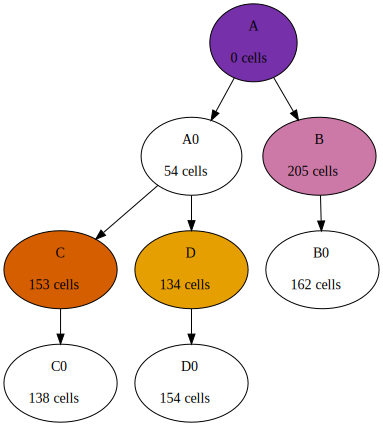

In [9]:
sca.ntssb.plot_tree(counts=True)

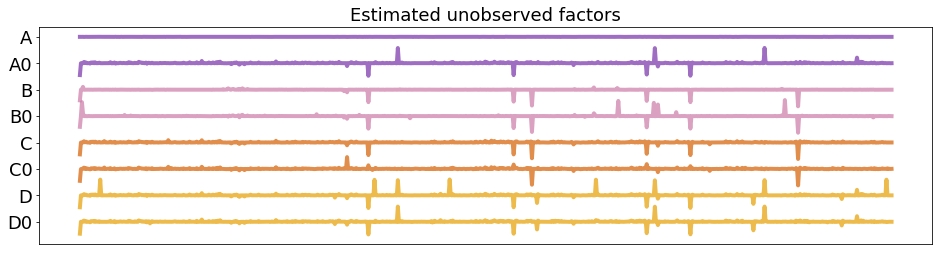

In [10]:
sca.plot_unobserved_parameters(step=5.,estimated=True, title='Estimated unobserved factors', 
                               name='unobserved_factors',figsize=(16,4))